<a href="https://colab.research.google.com/github/mattrosenblatt7/leakage_neuroimaging/blob/main/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import multiprocessing
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from scipy.stats import spearmanr
import glob
from matplotlib.ticker import FormatStrFormatter
import re
import colorcet as cc


In [ ]:
def calc_quantile(x, q):
    '''
    Compute quantile of data
    '''
    return x.quantile(q)


def two_line_text(txt):
    '''
    Function to place text onto two rows for axis or title labels
    '''

    words = txt.split(' ')
    word_lengths = [len(w)+1 for w in words]
    mid_loc = np.argmin(np.abs(np.cumsum(word_lengths) / np.sum(word_lengths)-0.5))
    words[mid_loc]+='\n'
    return ' '.join(words).replace('\n ', '\n')

In [ ]:
# sort it for right ordering
sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3, 'gold_zscore':4,
            'leak_zscore':5, 'leak_feature':6, 'leak_site':7, 'leak_covars':8, 'leak_family':9,
            'leak_subj_5':10, 'leak_subj_10':11, 'leak_subj_20':12}
# rename dictionary
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}

leakage_types_all = ['Gold standard',
                 'No covariate regression', 'No site correction',
                 'No site or covariate', 'Z-score phenotype',
                 'Leaky feature selection',
                'Leaky z-score',
                'Leaky site correction', 'Leaky covariate regression',
                 'Family leakage', 'Subject leakage (5%)',
                'Subject leakage (10%)', 'Subject leakage (20%)'

                ]


# color palette dictionary based on names
pal_all = ['black']
np.random.seed(4)
cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity
pal_all.extend([cmap_tmp[color_idx] for color_idx in color_shuffle_idx])
pal_dict = dict(zip(leakage_types_all, pal_all))

In [ ]:
github_file_link = 'https://github.com/mattrosenblatt7/leakage_neuroimaging/raw/main/data/source_data.xlsx'

# Figures 2-5

<ipython-input-6-c8ae3abb067d>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-6-c8ae3abb067d>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-6-c8ae3abb067d>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-6-c8ae3abb067d>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


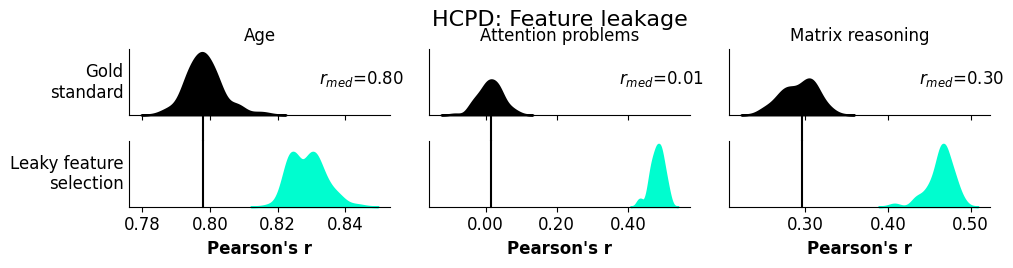

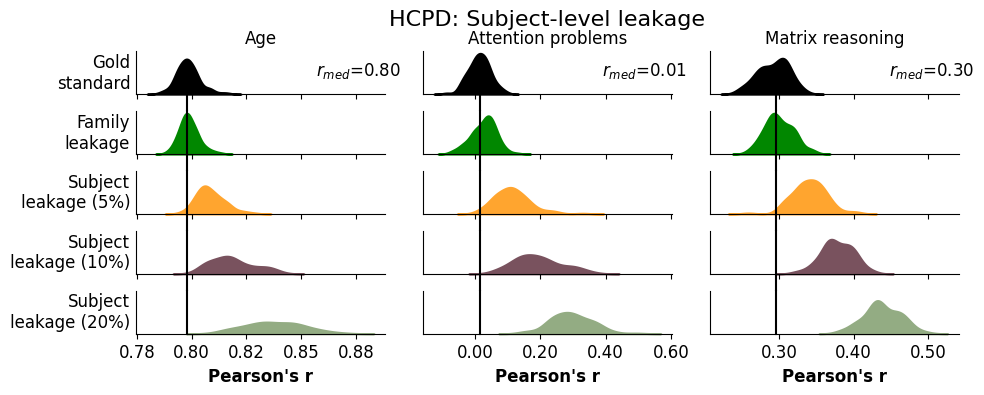

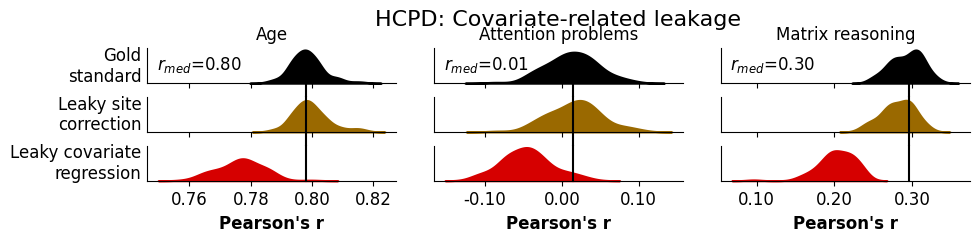

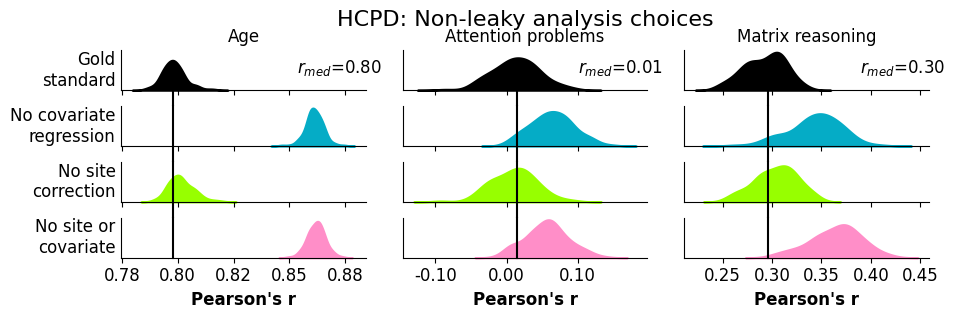

In [ ]:
'''
Plots for any combination of dataset/phenotype
you can modify these below:
-r_or_q2: choices ['r', 'q2']
-dataset: choices ['abcd', 'hbn', 'hcpd', 'pnc]
-leakage_cat: choices ['All pipelines', 'Feature leakage', 'Subject-level leakage', 'Covariate-related leakage', 'Non-leaky analysis chocies']
'''

dataset = 'hcpd'
r_or_q2 = 'r'

for leakage_cat in ['Feature leakage',
                    'Subject-level leakage',
                    'Covariate-related leakage',
                    'Non-leaky analysis choices']:

    # adjust some plot spacing
    if leakage_cat=='Feature leakage':
        plot_aspect = 2.5
        plot_height = 1.25
        fontsize=12
    elif (leakage_cat=='All pipelines') & ( (dataset!='hcpd') | (r_or_q2=='r') ):
        plot_aspect = 1.5
        plot_height = 1.5
        fontsize=12
    elif (leakage_cat=='All pipelines') & (dataset=='hcpd') & (r_or_q2=='q2'):
        plot_aspect = 3
        plot_height = 1.5
        fontsize = 12
    else:
        plot_aspect = 4
        plot_height = 0.75
        fontsize=12

    # set names of leakage types
    if leakage_cat=='Feature leakage':
        leakage_types = ['Gold standard', 'Leaky feature selection']
    elif leakage_cat=='Subject-level leakage':
        leakage_types = ['Gold standard', 'Family leakage', 'Subject leakage (5%)',
                        'Subject leakage (10%)', 'Subject leakage (20%)']
    elif leakage_cat=='Covariate-related leakage':
        leakage_types = ['Gold standard',
                        'Leaky site correction', 'Leaky covariate regression']
    elif leakage_cat=='Non-leaky analysis choices':
        leakage_types = ['Gold standard', 'No covariate regression', 'No site correction',
                          'No site or covariate']

    # find which sheet to load based on leakage type
    csv_save_path = '/content/drive/MyDrive/MINDS_lab/reproducibility/leakage/nat_comms_revisions/final_revisions/figures_final/data'
    if (dataset=='hcpd') and (leakage_cat=='Non-leaky analysis choices') and (r_or_q2=='r'):
      sheet_name = 'figure_2'
    if (dataset=='hcpd') and (leakage_cat=='Feature leakage') and (r_or_q2=='r'):
      sheet_name = 'figure_3'
    elif (dataset=='hcpd') and (leakage_cat=='Covariate-related leakage') and (r_or_q2=='r'):
      sheet_name = 'figure_4'
    elif (dataset=='hcpd') and (leakage_cat=='Subject-level leakage') and (r_or_q2=='r'):
      sheet_name = 'figure_5'

    # load data
    df_plot = pd.read_excel(github_file_link, sheet_name=sheet_name)

    # set palette
    pal = [pal_dict[l] for l in leakage_types]

    g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                      aspect=plot_aspect, height=plot_height,
                      col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                      row_order=leakage_types,
                      sharex='col', sharey='col',palette=pal,)

    # then we add the densities kdeplots
    g.map(sns.kdeplot, r_or_q2,
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)

    # adjust plot spacing
    if leakage_cat=='All pipelines':
        g.fig.subplots_adjust(hspace=0.4, wspace=0.15)
    else:
        g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


    for row_idx, ax_col in enumerate(g.axes):
        nrows = len(g.axes)
        for col_idx, ax in enumerate(ax_col):

            # if in first column and relevant datasets, set ylabel
            if (col_idx==0) & (((dataset=='hcpd') & (leakage_cat!='All pipelines'))\
                                | ((dataset=='hcpd') & (r_or_q2=='q2')) | (dataset=='abcd')):
                leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                leakage_type_str = two_line_text(leakage_type_str)
                ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

            else:
                ax.set_ylabel('')

            # if in first row, set title
            pheno_str = ax.title.get_text().split('=')[-1].strip()
            if row_idx==0:
                ax.set_title(pheno_str, fontsize=fontsize)
            else:
                ax.set_title('')

            # other formatting specifications
            ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_yticks([])

            # for last row
            if r_or_q2=='r':
                xlab = "Pearson's r"
            else:
                xlab = "$q^2$"
            ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

            # vertical line - the mean doesn't do anything since it's one value anyways
            gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                  (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
            if row_idx==0:
                ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
            elif row_idx==(nrows-1):
                ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
            else:
                ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

            # add text to axis with median r (gold_value)
            if row_idx==0:
                if leakage_cat=='Covariate-related leakage':
                    xloc = 0.21
                    yloc = 0.55
                elif leakage_cat=='All pipelines':
                    xloc = 0.85
                    yloc = 0.55
                else:
                    xloc = 0.89
                    yloc = 0.55

                if r_or_q2=='r':
                    ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                            ha='center', va='center', transform=ax.transAxes,
                            fontsize=12)
                elif r_or_q2=='q2':
                    ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                            ha='center', va='center', transform=ax.transAxes,
                            fontsize=12)


    # add in dataset title
    mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
    g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), leakage_cat),
                    ha='center',
                    va='top',
                    fontsize=fontsize+4,
                    fontweight=20,
                    x=mid, y=1.02)

# Figure 6

<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-7-b293dea63846>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


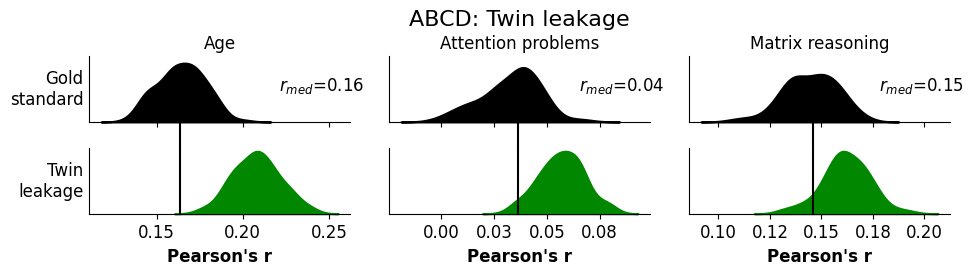

In [ ]:
'''
Twin leakage plot
'''

plot_aspect = 2.5
plot_height = 1.25
fontsize=12

# read data
df_plot = pd.read_excel(github_file_link, sheet_name='figure_6')

# plot data
g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                  aspect=plot_aspect, height=plot_height,
                  col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                  row_order=['Gold standard', 'Twin leakage'],
                  sharex='col', sharey='col',
                 palette=[(0.00392156862745098, 0.5294117647058824, 0.0), 'black', ])

# then we add the densities kdeplots f
g.map(sns.kdeplot, 'r',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)


# adjust plot spacing
g.fig.subplots_adjust(hspace=0.4, wspace=0.15)

for row_idx, ax_col in enumerate(g.axes):
    nrows = len(g.axes)
    for col_idx, ax in enumerate(ax_col):

        # if in first column and relevant datasets, set ylabel
        if (col_idx==0):
            leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
            leakage_type_str = two_line_text(leakage_type_str)
            ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')
        else:
            ax.set_ylabel('')

        # if in first row, set title
        pheno_str = ax.title.get_text().split('=')[-1].strip()
        if row_idx==0:
            ax.set_title(pheno_str, fontsize=fontsize)
        else:
            ax.set_title('')

        # other formatting specifications
        ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_yticks([])

        # for last row
        ax.set_xlabel("Pearson's r", fontweight='bold', fontsize=fontsize)

        # vertical line - the mean doesn't do anything since it's one value anyways
        gold_value = df_plot[(df_plot.leakage_type=='Gold standard') & (df_plot.pheno==pheno_str)]['r'].median()

        if row_idx==0:
            ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
        elif row_idx==(nrows-1):
            ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
        else:
            ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

        # add text to axis with median r (gold_value)
        if row_idx==0:
            xloc = 0.89
            yloc = 0.55

            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                    ha='center', va='center', transform=ax.transAxes,
                   fontsize=12)

    # add in dataset title
    mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
    _ = g.fig.suptitle('{:s}: {:s}'.format('ABCD', 'Twin leakage'),
               ha='center',
               va='top',
               fontsize=fontsize+4,
               fontweight=20,
               x=mid, y=1.05)

# Figure 7

<ipython-input-9-04fde08ee873>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all_withgold, y='leakage_type', x=r_or_q2+'_diff',
<ipython-input-9-04fde08ee873>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(leakage_type_str, fontsize=12, rotation=0, ha='right', va='center')
<ipython-input-9-04fde08ee873>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


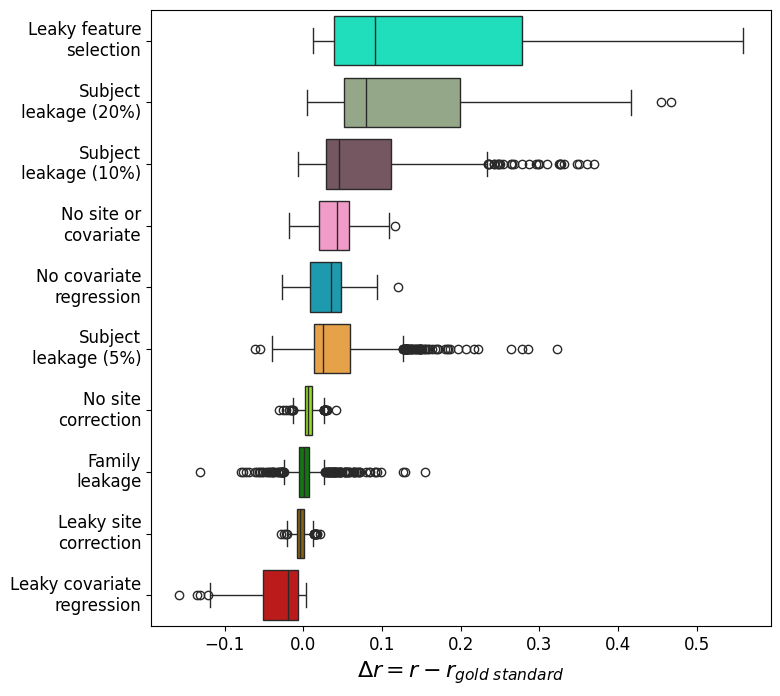

In [ ]:
'''
Change below to plot for r or q2 metric
This will make boxplots of performance difference between leaky analysis and "gold standard" across all datasets/phenotypes
'''
r_or_q2 = 'r'  # 'r', 'q2'

fig, ax = plt.subplots(figsize=(8, 8))

# load data
df_all_withgold = pd.read_excel(github_file_link, sheet_name='figure_7')

# rank leakage types by median difference over gold standard
leakage_diff_ranks = list(df_all_withgold.groupby(['leakage_type'], as_index=False).\
                          agg(r_diff_med=('r_diff', 'median'),
                             q2_diff_med=('q2_diff', 'median')).\
                          sort_values(by=r_or_q2+'_diff_med', ascending=False)['leakage_type'])
leakage_type_str = [two_line_text(l) for l in leakage_diff_ranks]

# colors
# palette based on smaller dataframe
pal = [pal_dict[l] for l in leakage_diff_ranks]

sns.boxplot(data=df_all_withgold, y='leakage_type', x=r_or_q2+'_diff',
            order=leakage_diff_ranks, ax=ax, palette=pal)

# this is if wanting label for both r and q2
if r_or_q2=='r':
    ax.set_xlabel('$\Delta r = r - r_{gold \ standard}$', fontsize=16)
elif r_or_q2=='q2':
    ax.set_xlabel('$\Delta q^2 = q^2 - q^2_{gold \ standard}$', fontsize=16)
ax.set_yticklabels(leakage_type_str, fontsize=12, rotation=0, ha='right', va='center')

ax.set_ylabel('')
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


# Figure 8

<ipython-input-11-50dd571ec3e6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)
<ipython-input-11-50dd571ec3e6>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='leakage_type', y=plot_type, ax=axs[row_idx, col_idx],
<ipython-input-11-50dd571ec3e6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

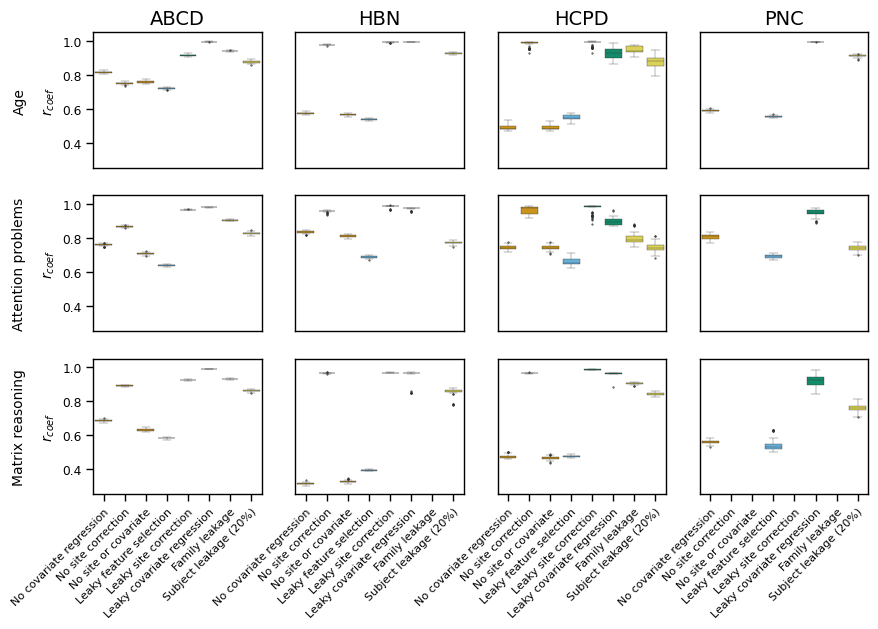

In [ ]:
# plots for coefficients, can either be r_coef or spearman rank between network counts for feature selection

# load data
df_all = pd.read_excel(github_file_link, sheet_name='figure_8')

coloring_type = 'leakage_family'  # '' or 'leakage_family', how to color boxes

plot_type = 'r_coef'  # r_coef, spearman_network_feat

pheno_all = ['age', 'ap', 'mr']
dataset_all = ['abcd', 'hbn', 'hcpd', 'pnc']
sns.set_context('paper')

# sort it for right ordering
all_leakage_types = [k for k in sort_dict.keys()]


npheno = len(pheno_all)
ndataset = len(dataset_all)
fig, axs = plt.subplots(nrows=npheno, ncols=ndataset, figsize=(10, 6))
for row_idx, pheno in enumerate(pheno_all):
    for col_idx, dataset in enumerate(dataset_all):

        df_plot = df_all[(df_all.pheno==pheno) & (df_all.dataset==dataset)]

        # rename columns
        df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)



        leakage_types = ['No covariate regression', 'No site correction',
                         'No site or covariate', 'Leaky feature selection',
                        'Leaky site correction', 'Leaky covariate regression',
                        'Family leakage', 'Subject leakage (20%)']

        # restrict plot df to just leakage types of interest
        df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

        df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

        ###################################### Actual plotting ######################################
        if coloring_type=='leakage_family':
            # updated palette by leakage type:
            # see https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
            pal = ['#E69F00', '#E69F00', '#E69F00',
                  '#56B4E9',
                  '#009E73', '#009E73',
                  '#F0E442','#F0E442']
        else:
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

        # new way: boxplot
        sns.boxplot(data=df_plot, x='leakage_type', y=plot_type, ax=axs[row_idx, col_idx],
                   palette=pal, order=leakage_types,
                    linewidth=0.25, fliersize=0.5)

        if plot_type=='spearman_network_feat':
            axs[row_idx, col_idx].set_ylim([0.15, 1.05])
        else:
            axs[row_idx, col_idx].set_ylim([0.25, 1.05])

        if row_idx == (npheno-1):
            axs[row_idx, col_idx].set_xlabel('Leakage type')
            axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45,
                                                  ha='right', fontsize=8, rotation_mode="anchor")
            axs[row_idx, col_idx].set_xlabel('')
        else:
            axs[row_idx, col_idx].set_xlabel('')
            axs[row_idx, col_idx].set_xticks([])

        if row_idx==0:
            axs[row_idx, col_idx].set_title(dataset.upper(), fontsize=14)

        if col_idx == 0:
            if plot_type=='spearman_network_feat':
                axs[row_idx, col_idx].set_ylabel('$r_{rank,network}$', fontsize=10)
            elif plot_type=='r_coef':
                axs[row_idx, col_idx].set_ylabel('$r_{coef}$', fontsize=10)

            # add y label
            if pheno=='ap':
                y_lab_bigtext = 'Attention problems'
            elif pheno=='age':
                y_lab_bigtext = 'Age'
            elif pheno=='mr':
                y_lab_bigtext = 'Matrix reasoning'

            # adjust y label location based on which plot type
            if plot_type=='spearman_network_feat':
                yloc = 0.6
            else:
                yloc = 0.65

            axs[row_idx, col_idx].text(-4, yloc, y_lab_bigtext,
                                       rotation=90, ha='center', va='center',fontsize=10)
        else:
            axs[row_idx, col_idx].set_ylabel('')
            axs[row_idx, col_idx].set_yticks([])



# Figure 9

<ipython-input-12-b0c0d59eac0d>:46: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.catplot(


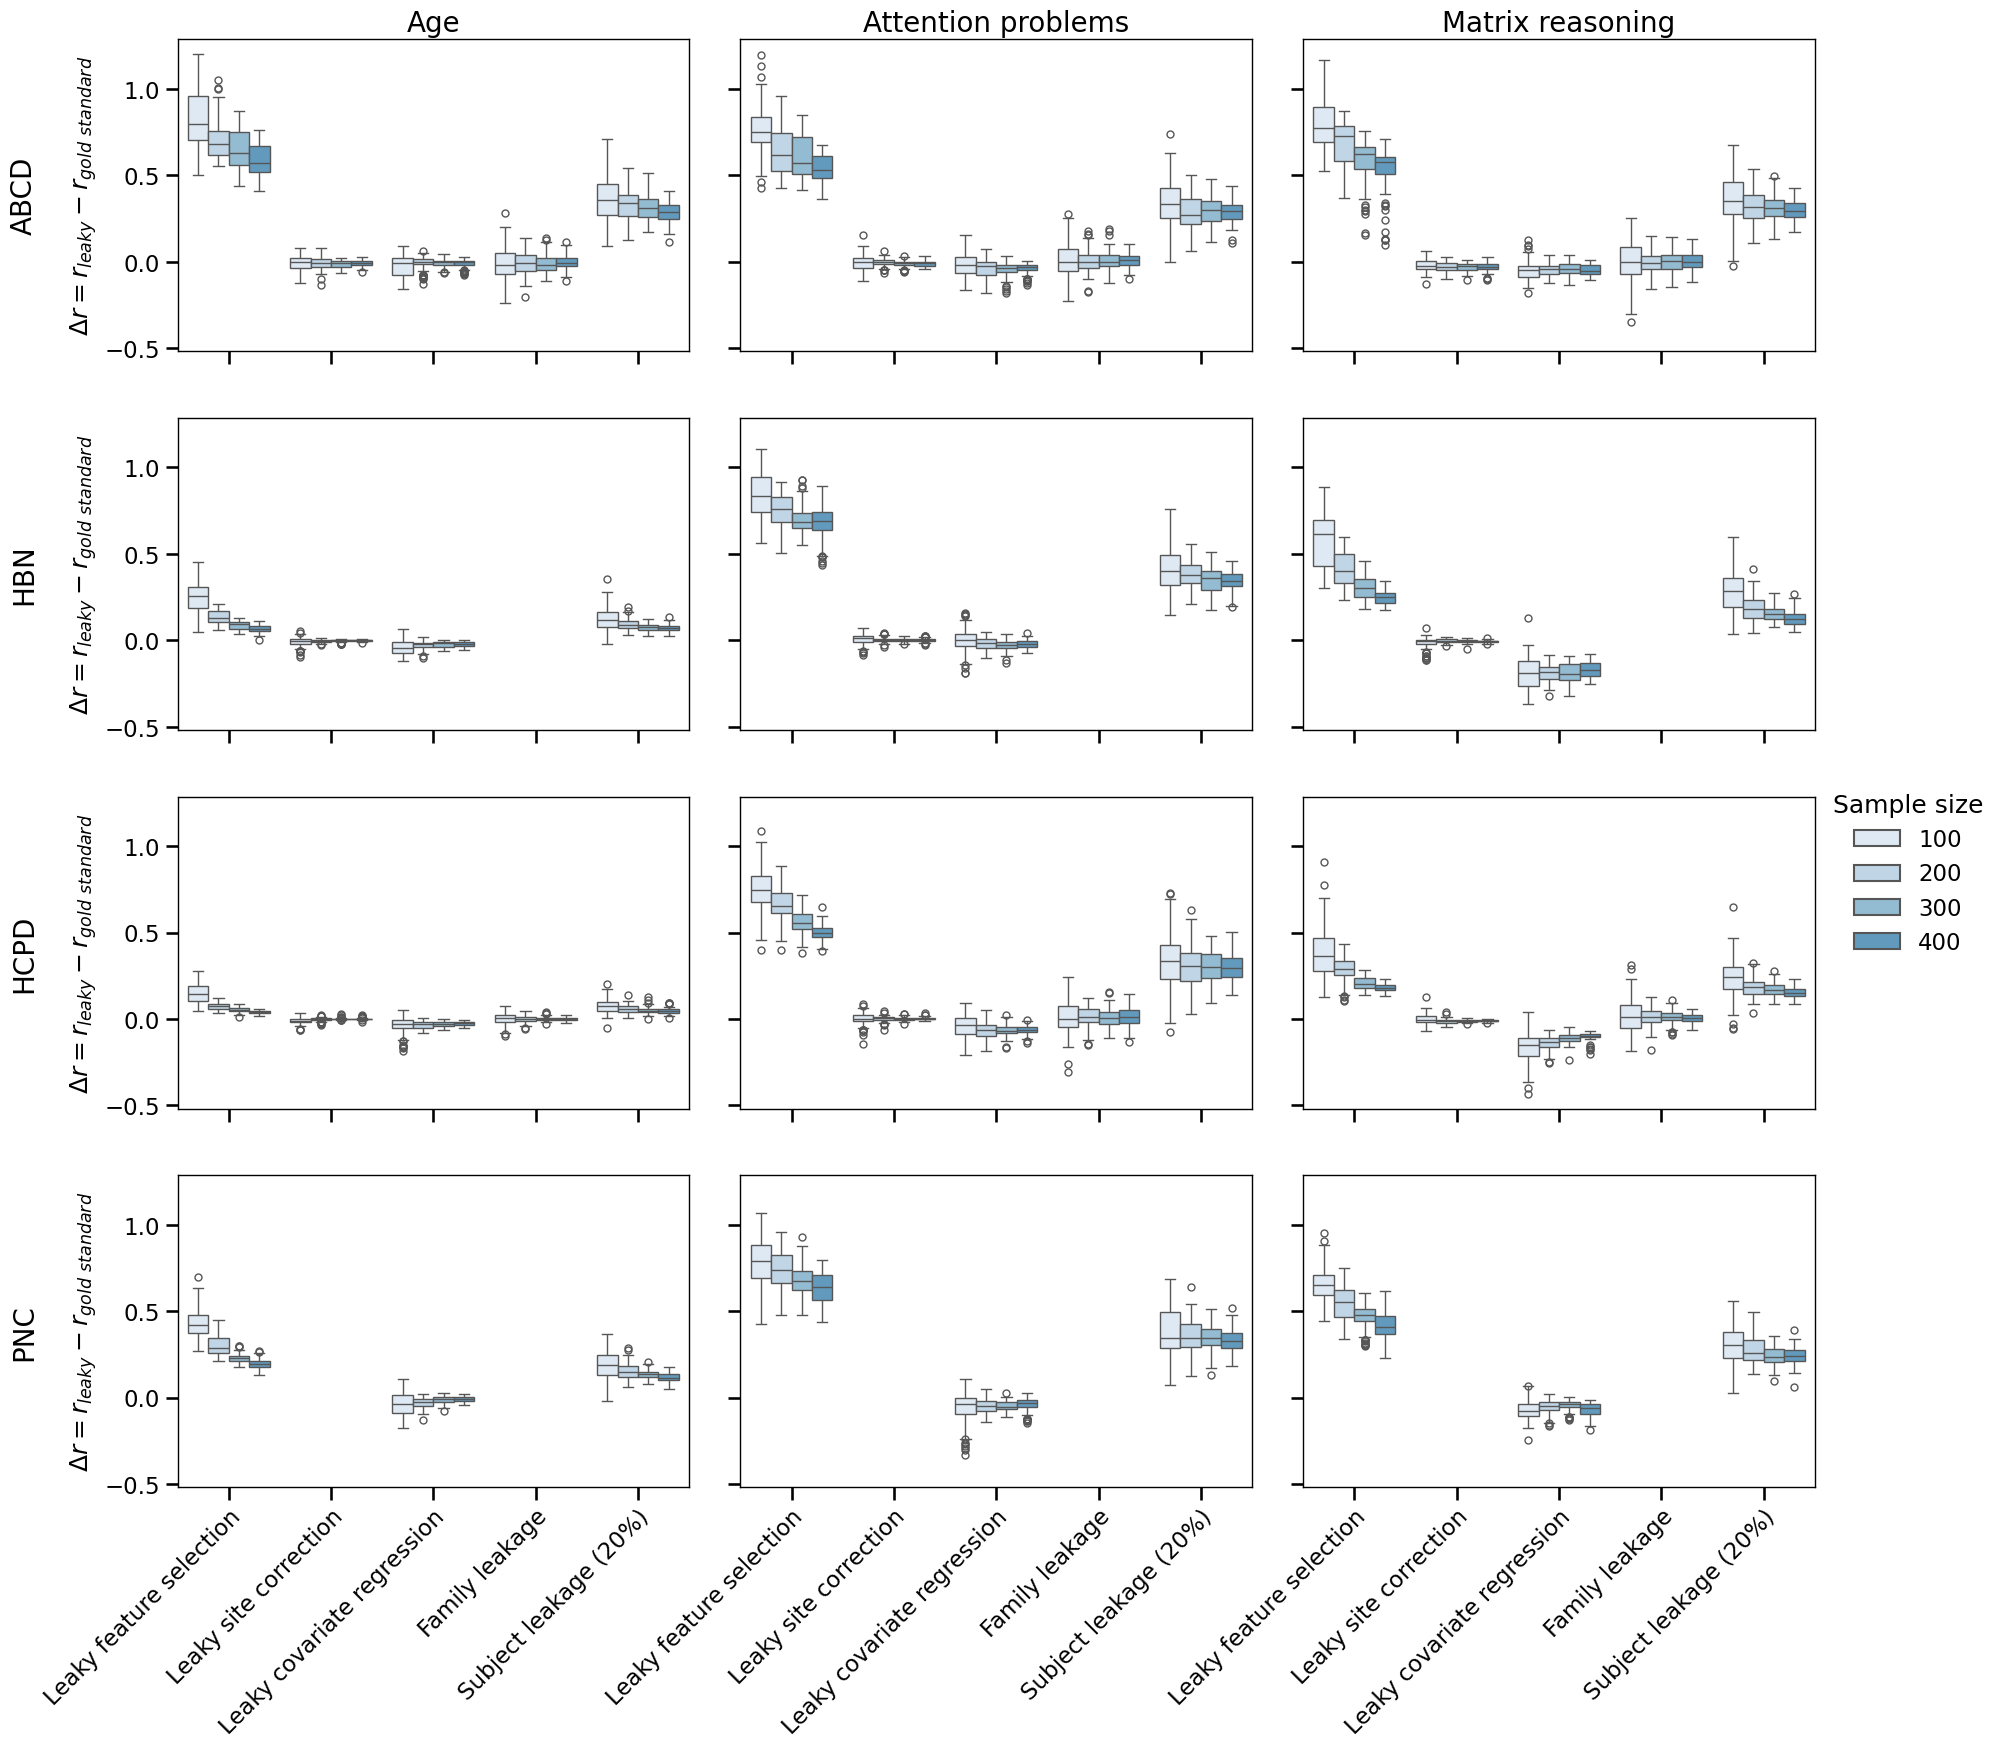

In [ ]:
'''
Plot across all k-fold and resample seeds
'''

# load sample size data
df_all = pd.read_excel(github_file_link, sheet_name='figure_9')
df_all['r_diff'] = df_all['r'] - df_all['r_gold']

# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# set some plot parameters
sns.set_context('talk')

# restrict plot to only leakage types of interest
df_plot = df_all[df_all.leakage_type.isin(['leak_covars', 'leak_family', 'leak_feature', 'leak_site', 'leak_subj_20'])]

# sort leakage types for plot ordering
sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3, 'gold_zscore':4,
            'leak_zscore':5, 'leak_feature':6, 'leak_site':7, 'leak_covars':8, 'leak_family':9,
            'leak_subj_5':10, 'leak_subj_10':11, 'leak_subj_20':12}
all_leakage_types = [k for k in sort_dict.keys()]

# set dictionary to change names of leakage types
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regresion',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}

# sort it
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]

# rename columns
df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)

# rename phenotypes
df_plot['pheno'] = df_plot['pheno'].replace({'age':'Age', 'ap':'Attention problems', 'mr':'Matrix reasoning'})

leakage_types = list(df_plot.leakage_type.unique())

# for pheno in cols
g = sns.catplot(
    data=df_plot, x='leakage_type', y='r_diff', hue='sample_size',
    col='pheno', row='dataset',
    kind='box',
    palette=sns.color_palette("Blues"),
    height=4, aspect=1.5,
    order=leakage_types,
    col_order=['Age', 'Attention problems', 'Matrix reasoning'],
    row_order=['abcd', 'hbn', 'hcpd', 'pnc']
)


g.set_xticklabels(leakage_types, rotation=45, ha='right', rotation_mode='anchor')
g.set_axis_labels('', '$\Delta r = r_{leaky} - r_{gold \ standard}$')

# legend title
g.legend.set_title('Sample size')

# decrease width space (hspace for height)
g.fig.subplots_adjust(wspace=0.1)


# update axis labeling
for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip().replace('pheno = ', ''), fontsize=20)
        else:
            axes_col.set_title('')


        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(ylabel)

            axes_col.text(-0.3, 0.5, row.strip().replace('dataset = ', '').upper(),
                          fontsize=20, transform=axes_col.transAxes, rotation=90,
               horizontalalignment = 'center', verticalalignment='center')

# add box around axes
for ax in g.axes.flatten(): # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)

plt.show()



# Figure 10

In [ ]:
# load data
df_all =  pd.read_excel(github_file_link, sheet_name='figure_10')

# group data to get median results
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
# merge in mean/median results
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                      right_on=['leakage_type', 'dataset', 'pheno'])

# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)

# sort by leakage type
df_all = df_all.sort_values('leakage_type')

<ipython-input-15-b5d0d0c3cebb>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


Text(0.5335339506172839, 1.02, 'HCPD (DTI): All pipelines')

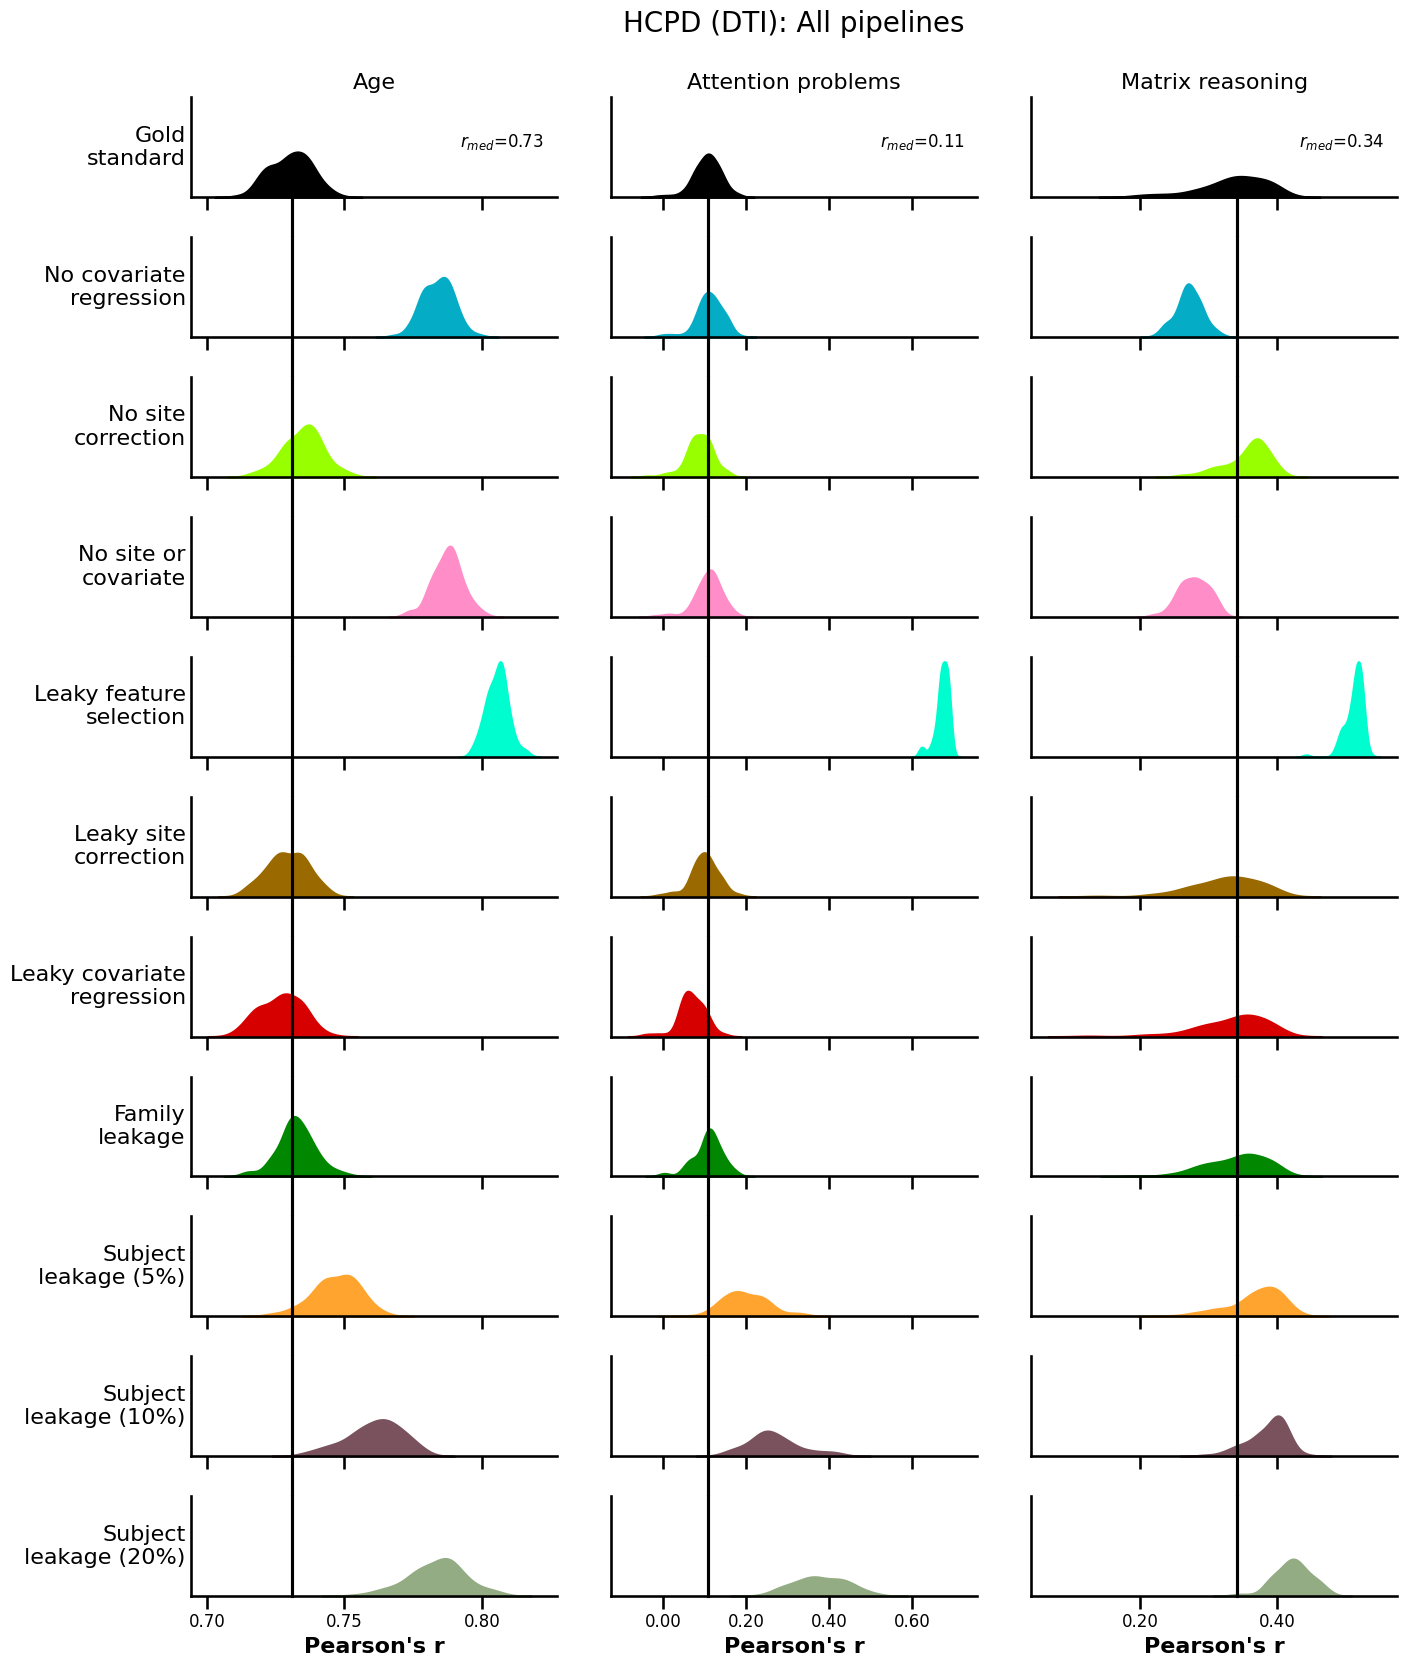

In [ ]:
'''
Plots for DTI results, set r and q2 below
'''

# rename dataset
df_all['dataset'] = df_all['dataset'].replace('hcpddti', 'HCPD (DTI)')

r_or_q2 = 'r'  # 'r' 'q2'
dataset = 'HCPD (DTI)'

# restrict to dti data
df_plot = df_all[(df_all.dataset==dataset)]

# sort it by leakage type
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


# rename leakage types
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
                'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
                'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
                'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
                'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
                'leak_subj_20':'Subject leakage (20%)'}
df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)



# color palette dictionary based on names
pal_all = ['black']
np.random.seed(4)
cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity

leakage_types = ['Gold standard',
                  'No covariate regression', 'No site correction',
                  'No site or covariate',
                  'Leaky feature selection',
                'Leaky site correction', 'Leaky covariate regression',
                  'Family leakage', 'Subject leakage (5%)',
                'Subject leakage (10%)', 'Subject leakage (20%)'

                ]


# restrict plot df to just leakage types of interest
df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                            'mr':'Matrix reasoning',
                                            'age':'Age'})

###################################### Actual plotting ######################################
# palette based on smaller dataframe
pal = [pal_dict[l] for l in leakage_types]

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
plot_aspect = 3
plot_height = 1.5
fontsize = 16

g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                  aspect=plot_aspect, height=plot_height,
                  palette=pal,
                  col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                  row_order=leakage_types,
                  sharex='col', sharey='col')

# then we add the densities kdeplots f
g.map(sns.kdeplot, r_or_q2,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# adjust plot spacing
g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


for row_idx, ax_col in enumerate(g.axes):
    nrows = len(g.axes)
    for col_idx, ax in enumerate(ax_col):

        # if in first column and relevant datasets, set ylabel
        if (col_idx==0):
            leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
            leakage_type_str = two_line_text(leakage_type_str)
            ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

        else:
            ax.set_ylabel('')

        # if in first row, set title
        pheno_str = ax.title.get_text().split('=')[-1].strip()
        if row_idx==0:
            ax.set_title(pheno_str, fontsize=fontsize)
        else:
            ax.set_title('')

        # other formatting specifications
        ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_yticks([])

        # for last row
        if r_or_q2=='r':
            xlab = "Pearson's r"
        else:
            xlab = "$q^2$"
        ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

        # vertical line - the mean doesn't do anything since it's one value anyways
        gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                              (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
        if row_idx==0:
            ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
        elif row_idx==(nrows-1):
            ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
        else:
            ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

        # add text to axis with median r (gold_value)
        if row_idx==0:
            xloc = 0.85
            yloc = 0.55

            if r_or_q2=='r':
                ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=12)
            elif r_or_q2=='q2':
                ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=12)


# add in dataset title
mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), 'All pipelines'),
                ha='center',
                va='top',
                fontsize=fontsize+4,
                fontweight=20,
                x=mid, y=1.02)


# Supplementary Figures 1, 5, 6

gold_zscore
leak_zscore


<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_zscore
leak_zscore
leak_family


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_zscore
leak_zscore


<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_minus_site
gold_minus_site_covars
gold_zscore
leak_zscore
leak_site
leak_family


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_

gold_zscore
leak_zscore


<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_zscore
leak_zscore
leak_family


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_zscore
leak_zscore


<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_minus_site
gold_minus_site_covars
gold_zscore
leak_zscore
leak_site
leak_family


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
<ipython-input-16-3e089611fed3>:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_

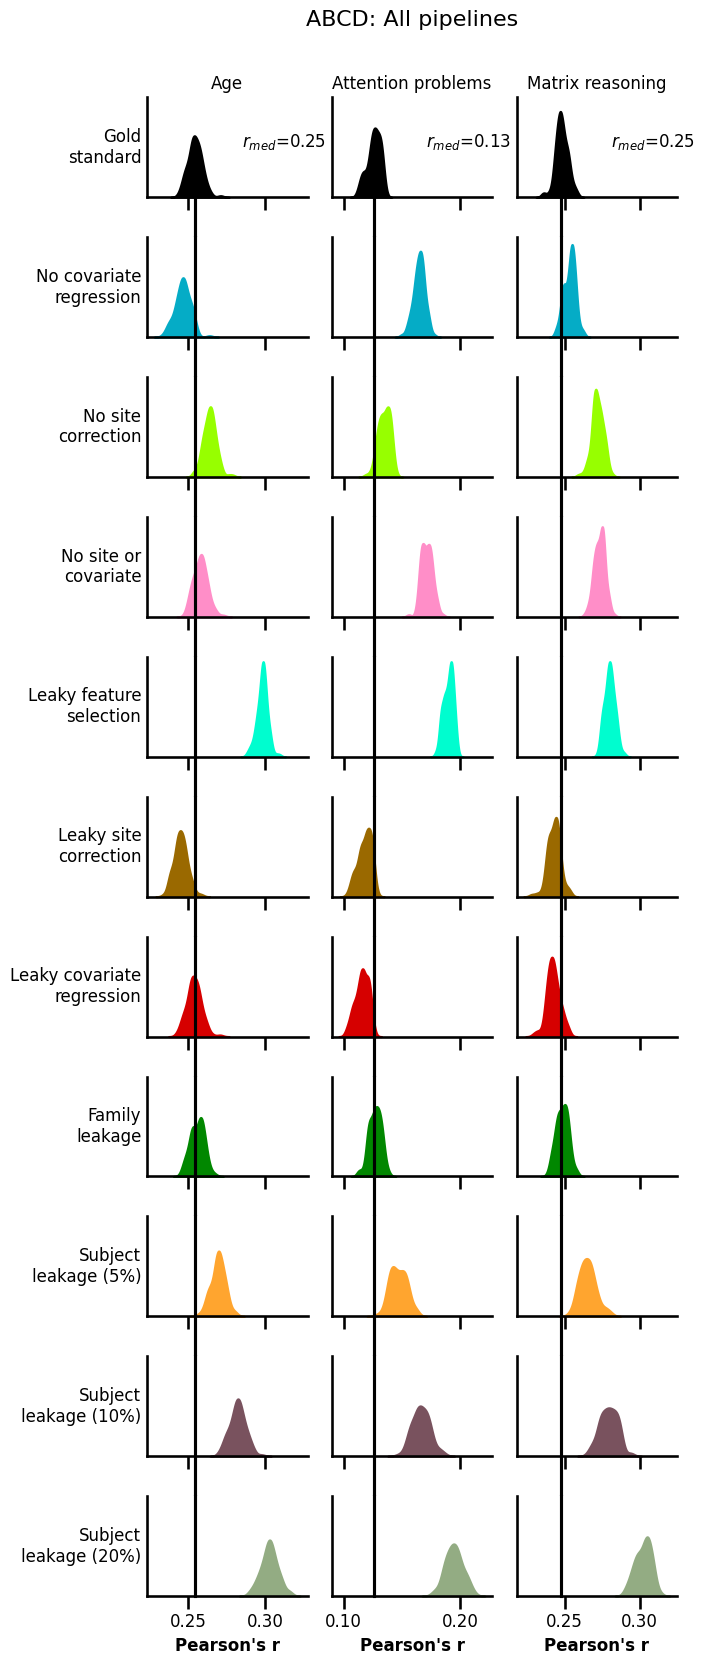

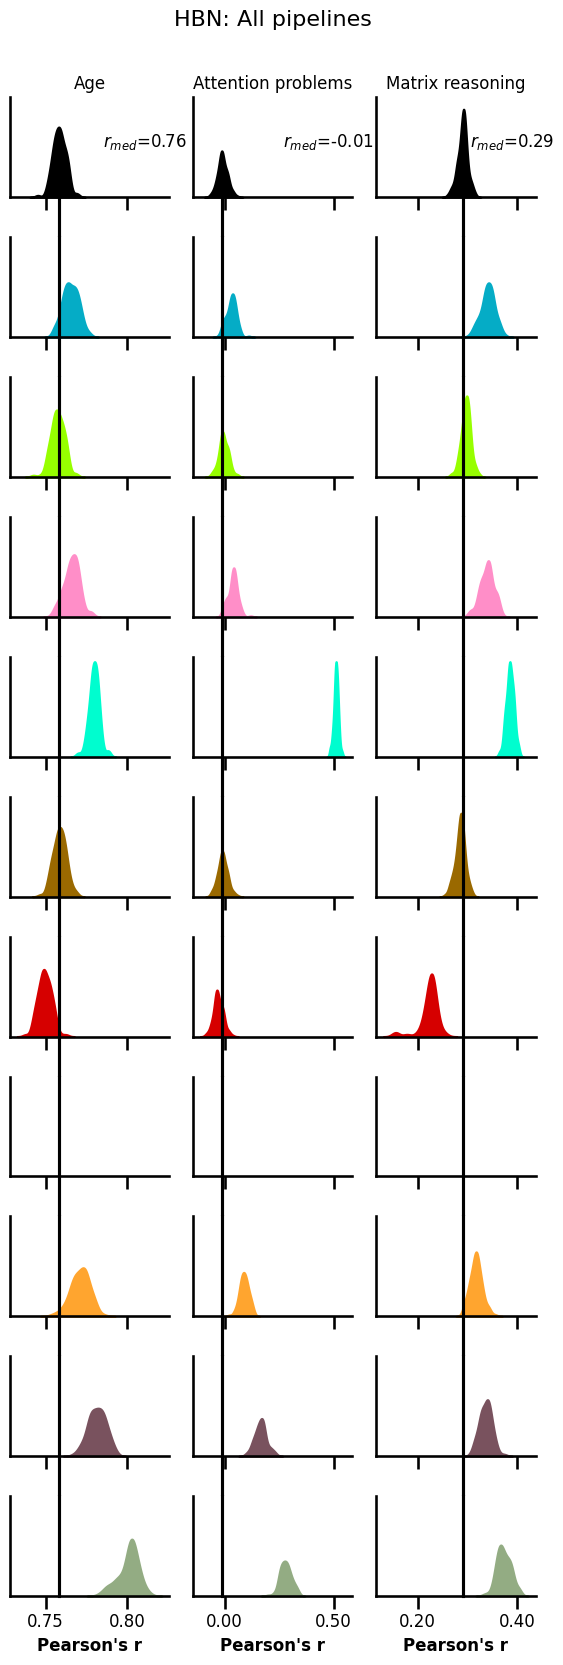

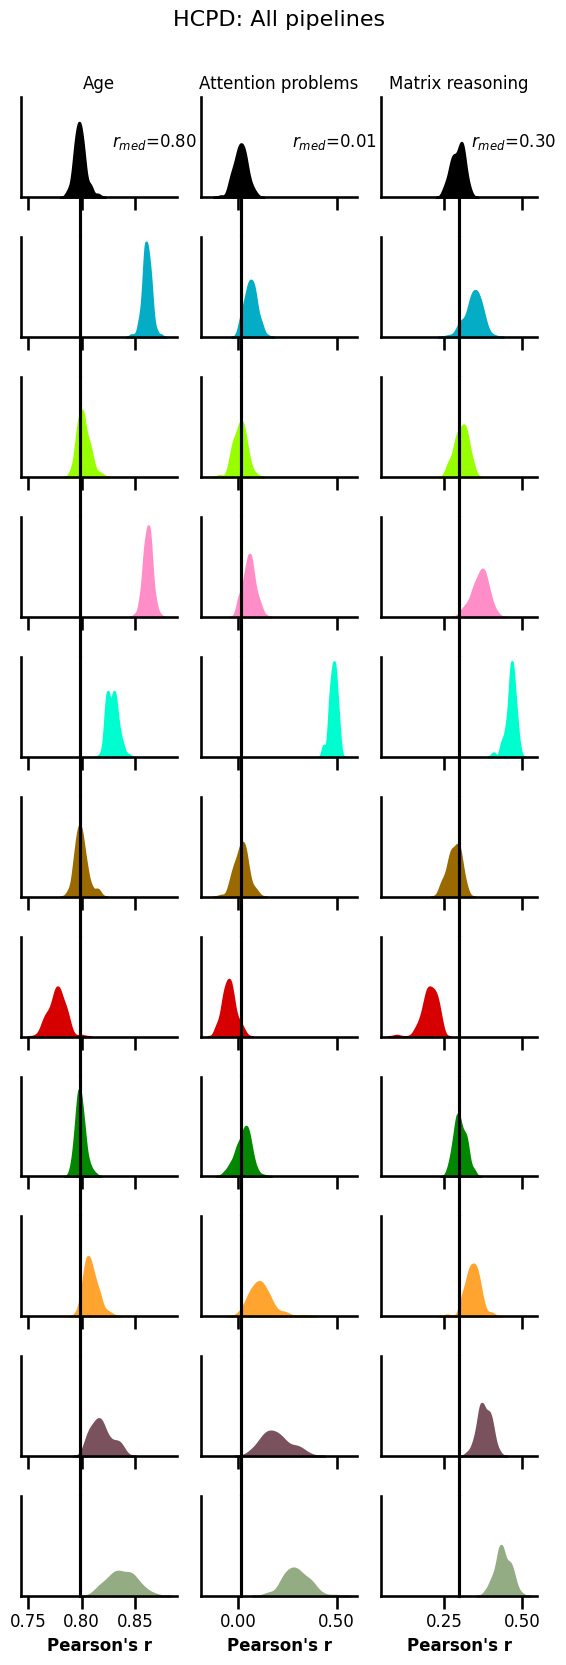

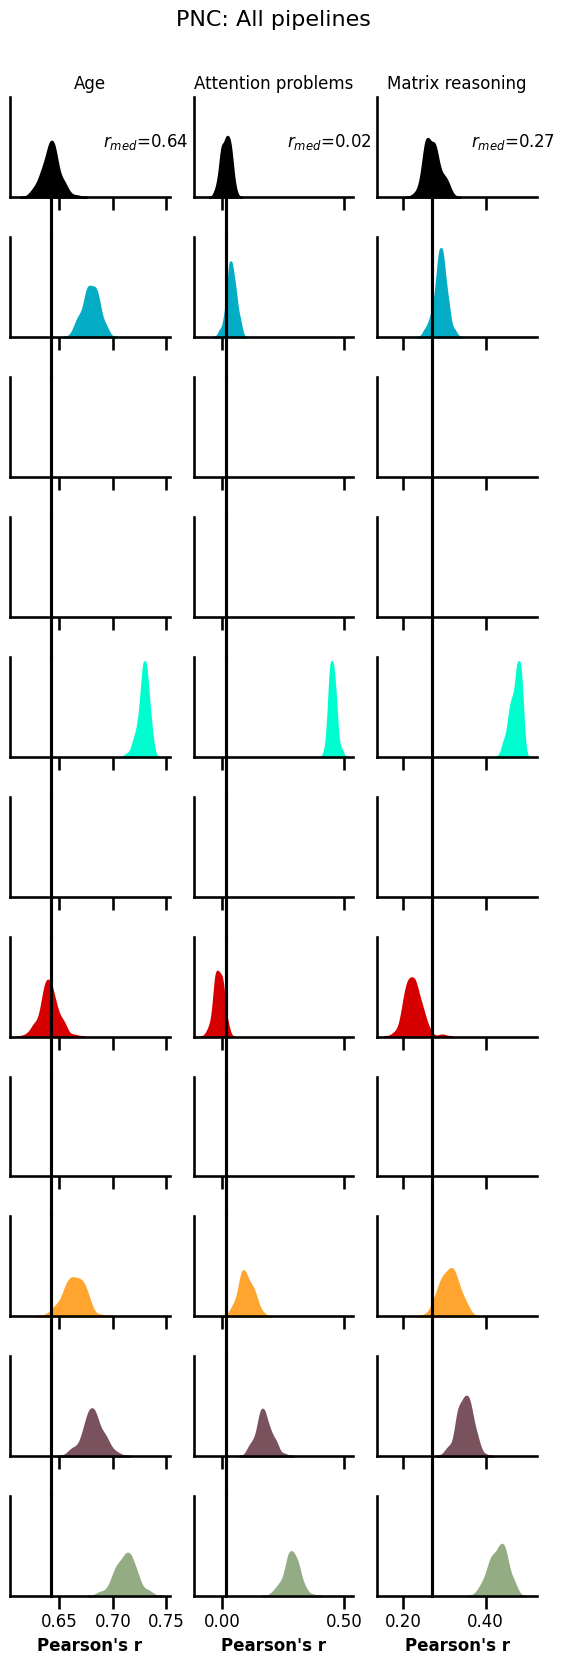

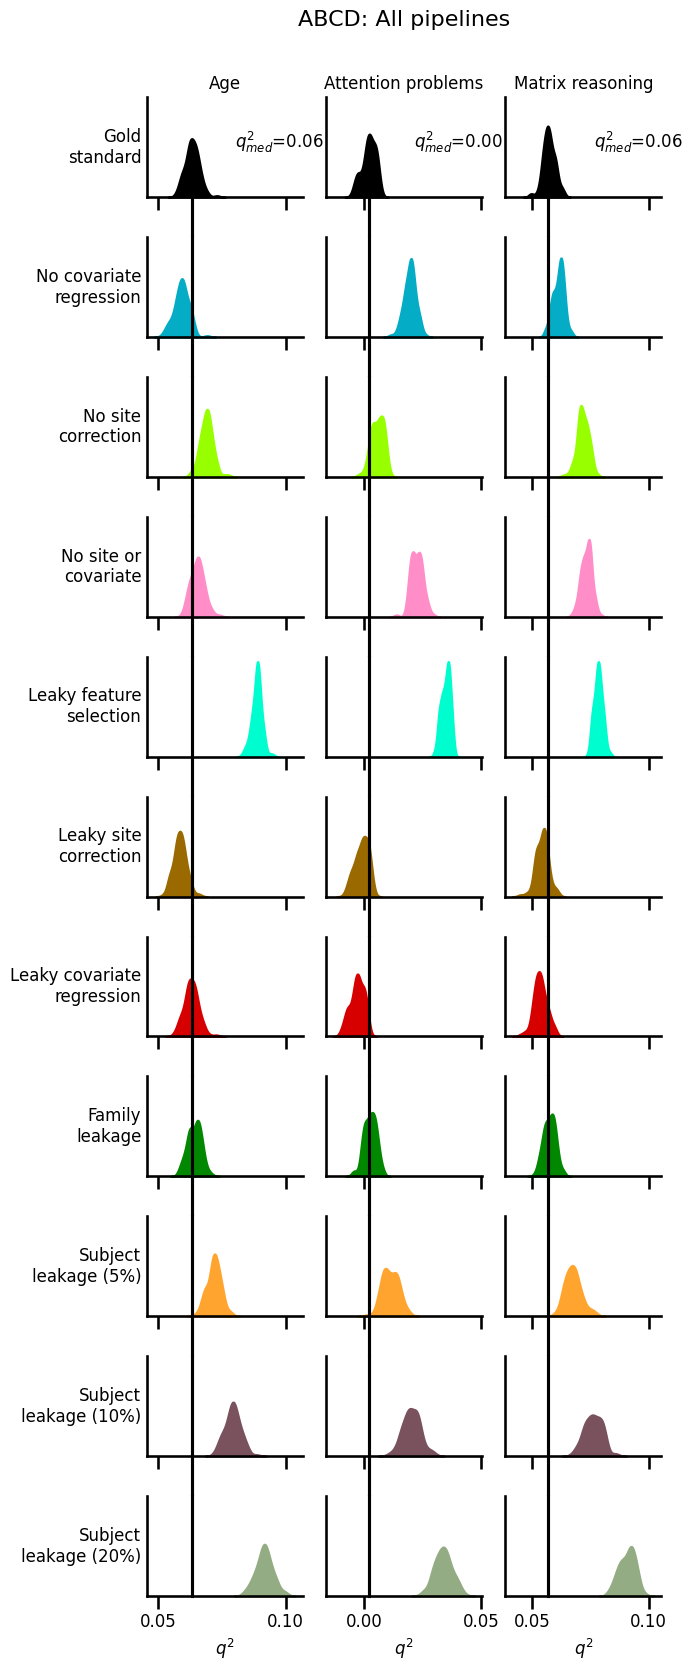

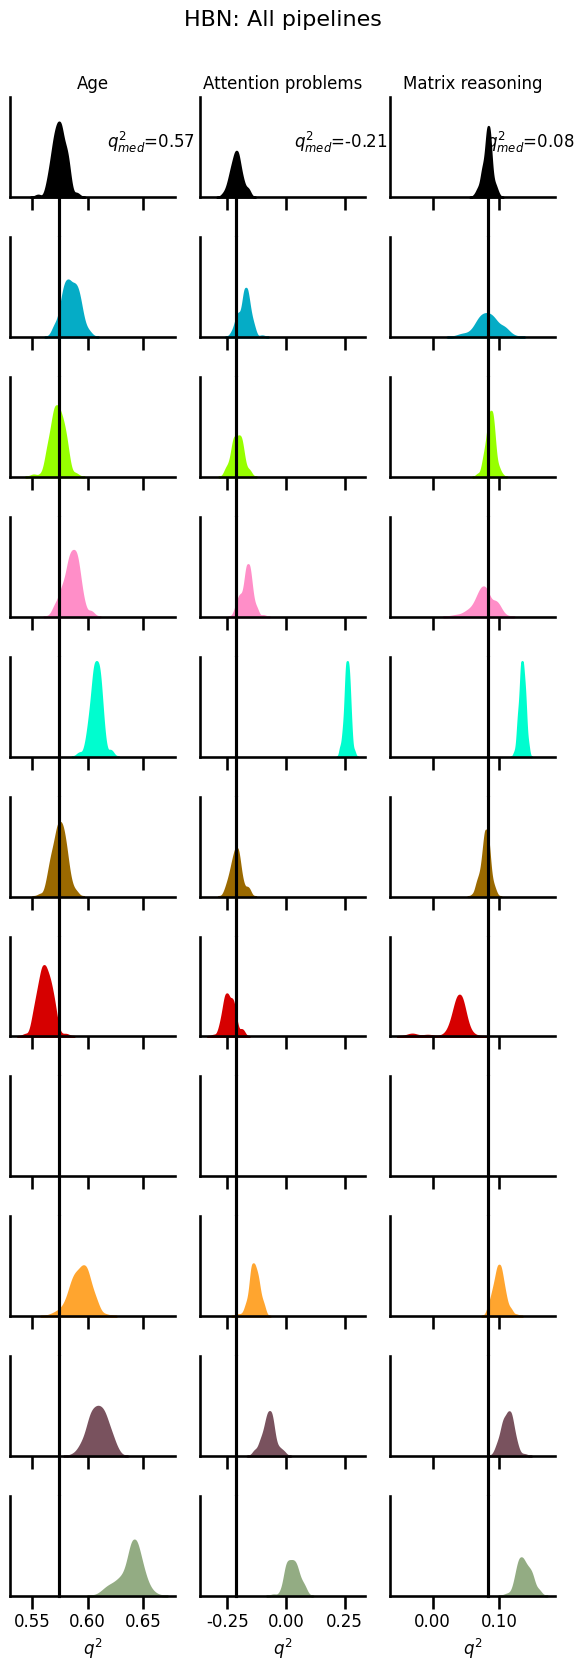

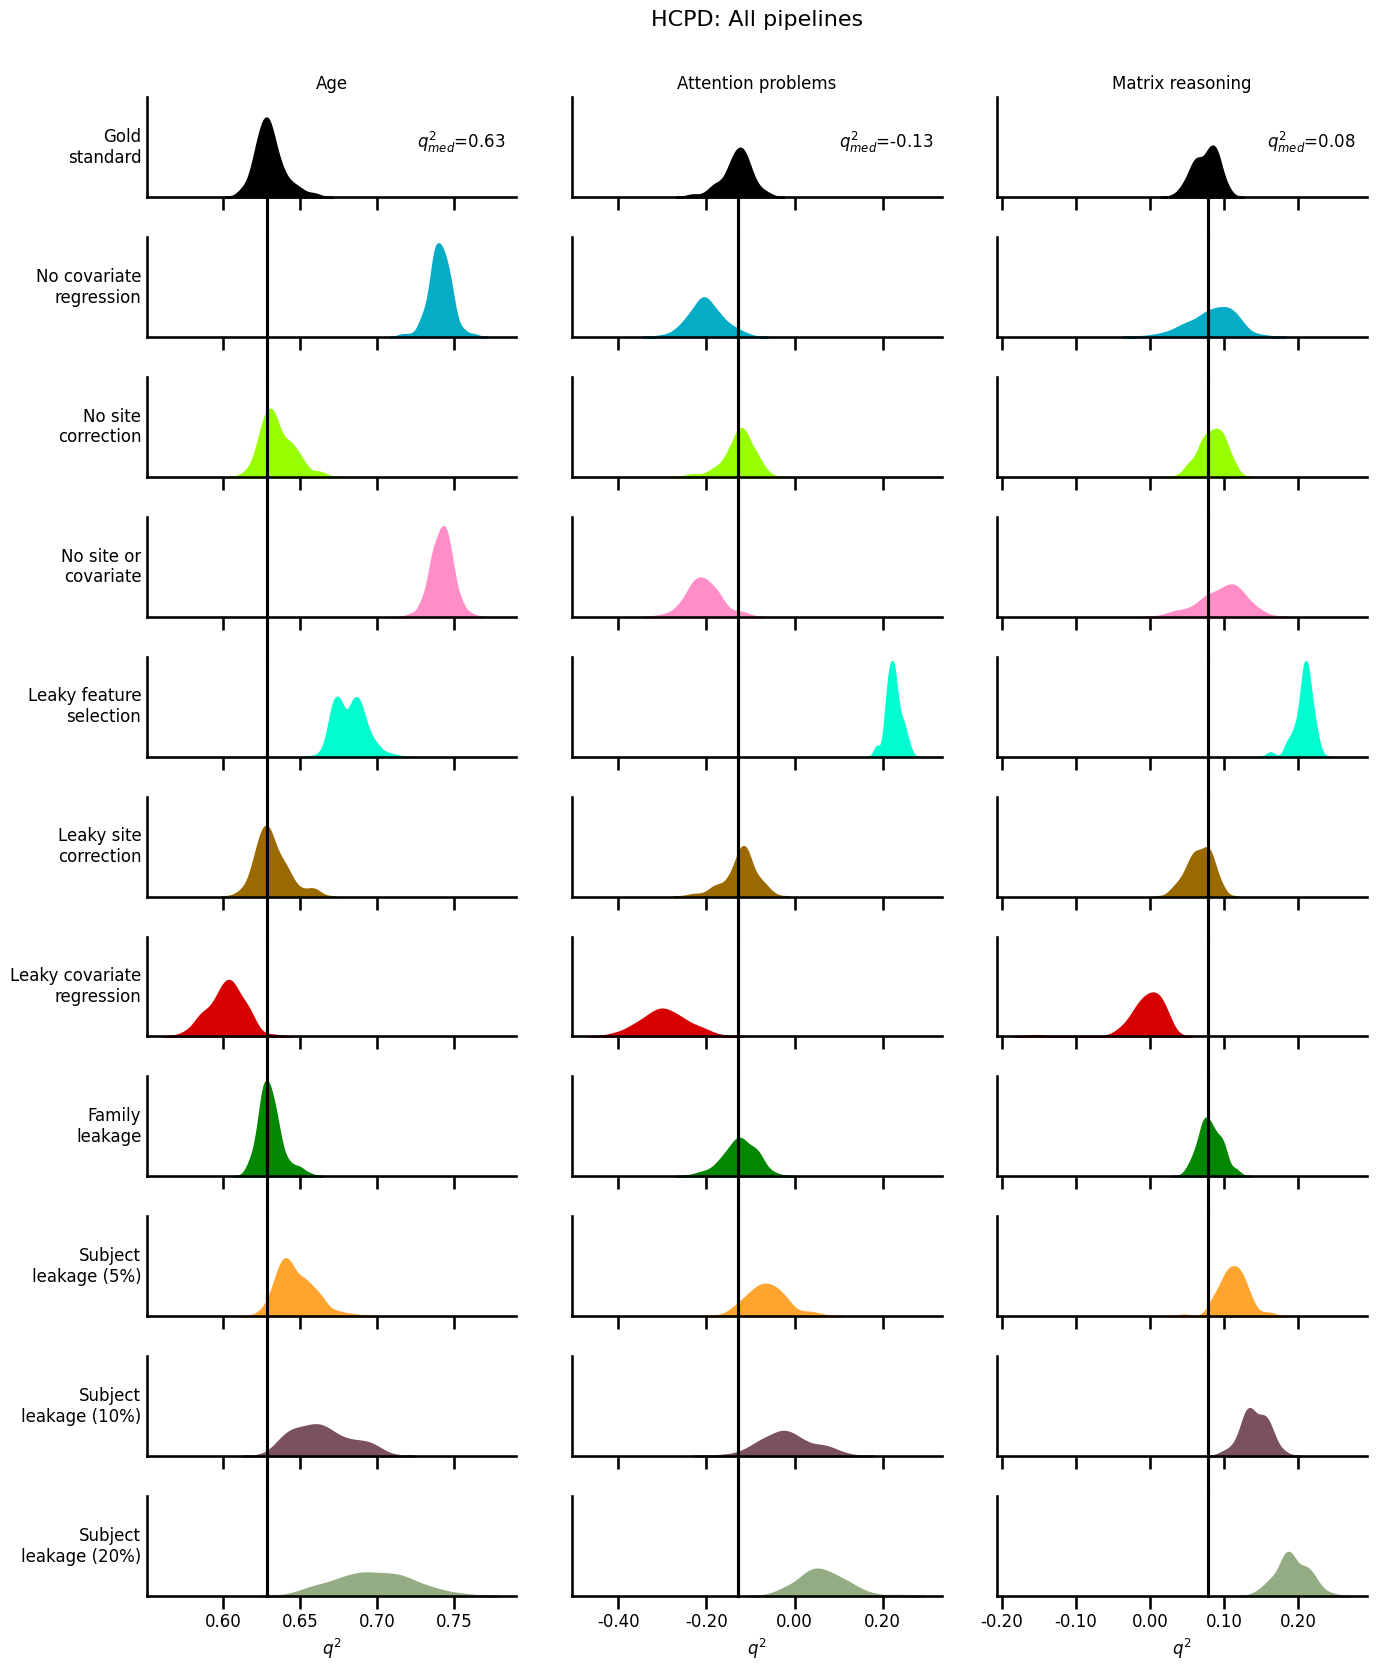

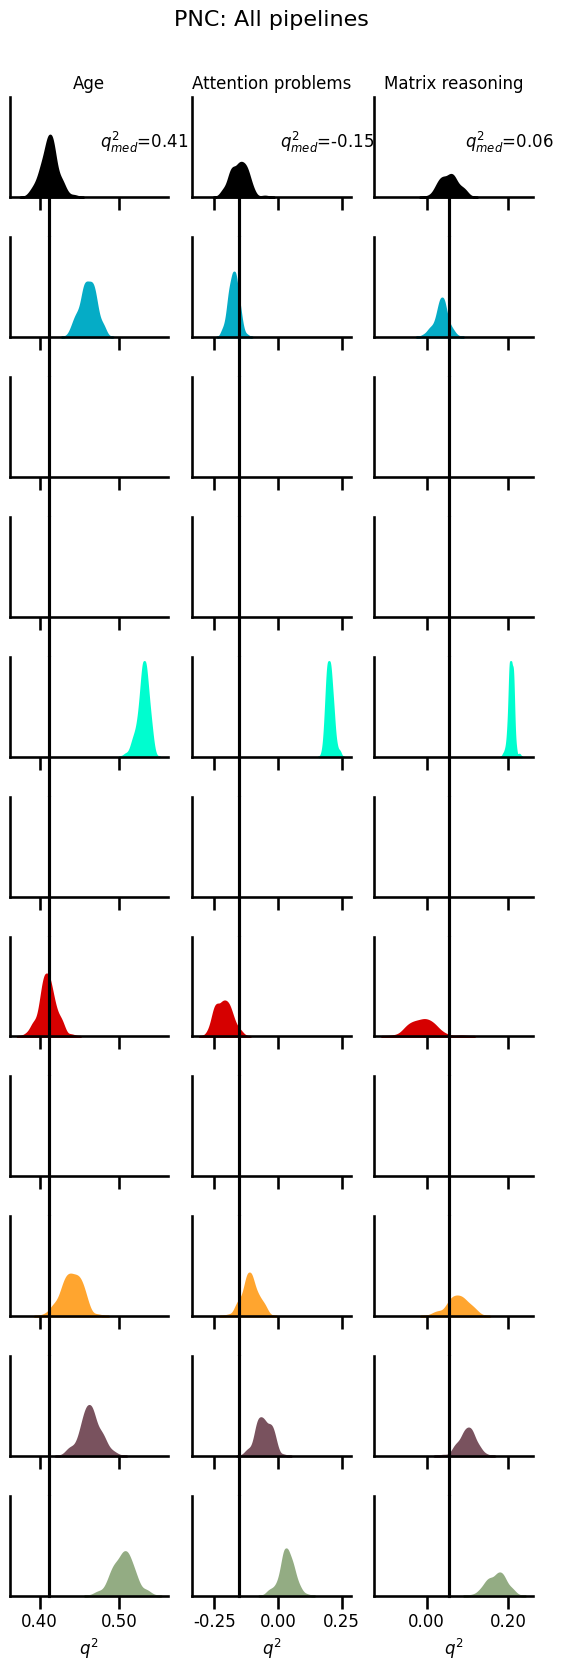

In [ ]:
# df_all = pd.read_excel(os.path.join(csv_save_path,'source_data.xlsx'), sheet_name='figure_s1')
df_all = pd.read_excel(github_file_link, sheet_name='figure_s1')
'''
Plots for any combination of dataset/phenotype
you can modify these below:
-r_or_q2: choices ['r', 'q2']
-dataset: choices ['abcd', 'hbn', 'hcpd', 'pnc]
-leakage_cat: choices ['All pipelines', 'Feature leakage', 'Subject-level leakage', 'Covariate-related leakage', 'Non-leaky analysis chocies']
'''

r_or_q2 = 'q2'
pheno = 'mr'
dataset = 'hcpd'
for r_or_q2 in ['r', 'q2']:
    for dataset in ['abcd', 'hbn', 'hcpd', 'pnc']:
        for leakage_cat in ['All pipelines']:

            '''
            Copy below for all
                            'All pipelines',
                            'Feature leakage',
                            'Subject-level leakage',
                            'Covariate-related leakage',
                           'Non-leaky analysis choices'
            '''

            if dataset=='abcd':
                ylab = True
            else:
                ylab = False

            ylab = False

            df_plot = df_all[(df_all.dataset==dataset)]

            # add in missing keys
            all_leakage_types = [k for k in sort_dict.keys()]
            for k in sort_dict.keys():
                if k not in df_plot.leakage_type.unique():
                    print(k)
                    df_tmp = pd.DataFrame(np.nan, index=[0], columns=df_plot.keys())
                    df_tmp['dataset'] = dataset
                    df_tmp['pheno'] = pheno
                    df_tmp['leakage_type'] = k
                    df_tmp['r'] = df_plot.r.mean()
                    df_tmp['med_r'] = np.nan
                    df_tmp['q2'] = df_plot.q2.mean()
                    df_tmp['med_q2'] = np.nan
                    df_plot = pd.concat([df_plot, df_tmp])

            # sort it
            df_plot = df_plot.reset_index(drop=True)
            df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


            # rename
            df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)




            if leakage_cat=='Feature leakage':
                leakage_types = ['Gold standard', 'Leaky feature selection']
            elif leakage_cat=='Subject-level leakage':
                leakage_types = ['Gold standard', 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)']
            elif leakage_cat=='Covariate-related leakage':
                leakage_types = ['Gold standard',
                                'Leaky site correction', 'Leaky covariate regression']
            elif leakage_cat=='Non-leaky analysis choices':
                leakage_types = ['Gold standard', 'No covariate regression', 'No site correction',
                                 'No site or covariate']
            elif leakage_cat=='All pipelines':
                leakage_types = ['Gold standard',
                                 'No covariate regression', 'No site correction',
                                 'No site or covariate',
                                 'Leaky feature selection',
                                'Leaky site correction', 'Leaky covariate regression',
                                 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)'

                                ]


            # restrict plot df to just leakage types of interest
            df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

            df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

            ###################################### Actual plotting ######################################
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

            # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
            if leakage_cat=='Feature leakage':
                plot_aspect = 2.5
                plot_height = 1.25
                fontsize=12
            elif (leakage_cat=='All pipelines') & ( (dataset!='hcpd') | (r_or_q2=='r') ):
                plot_aspect = 1.5
                plot_height = 1.5
                fontsize=12
            elif (leakage_cat=='All pipelines') & (dataset=='hcpd') & (r_or_q2=='q2'):
                plot_aspect = 3
                plot_height = 1.5
                fontsize = 12
            else:
                plot_aspect = 4
                plot_height = 0.75
                fontsize=12

            csv_save_path = '/content/drive/MyDrive/MINDS_lab/reproducibility/leakage/nat_comms_revisions/final_revisions/figures_final/data'
            if (dataset=='hcpd') and (leakage_cat=='Non-leaky analysis choices') and (r_or_q2=='r'):
              df_plot.to_csv(os.path.join(csv_save_path,'figure2.csv'), index=False)
            if (dataset=='hcpd') and (leakage_cat=='Feature leakage') and (r_or_q2=='r'):
              df_plot.to_csv(os.path.join(csv_save_path,'figure3.csv'), index=False)
            elif (dataset=='hcpd') and (leakage_cat=='Covariate-related leakage') and (r_or_q2=='r'):
              df_plot.to_csv(os.path.join(csv_save_path,'figure4.csv'), index=False)
            elif (dataset=='hcpd') and (leakage_cat=='Subject-level leakage') and (r_or_q2=='r'):
              df_plot.to_csv(os.path.join(csv_save_path,'figure5.csv'), index=False)


            g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                              aspect=plot_aspect, height=plot_height,
                              col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                              row_order=leakage_types,
                              sharex='col', sharey='col',palette=pal,)

            # then we add the densities kdeplots
            g.map(sns.kdeplot, r_or_q2,
                  bw_adjust=1, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)

            # adjust plot spacing
            if leakage_cat=='All pipelines':
                g.fig.subplots_adjust(hspace=0.4, wspace=0.15)
            else:
                g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


            for row_idx, ax_col in enumerate(g.axes):
                nrows = len(g.axes)
                for col_idx, ax in enumerate(ax_col):

                    # if in first column and relevant datasets, set ylabel
                    if (col_idx==0) & (((dataset=='hcpd') & (leakage_cat!='All pipelines'))\
                                       | ((dataset=='hcpd') & (r_or_q2=='q2')) | (dataset=='abcd')):
                        leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                        leakage_type_str = two_line_text(leakage_type_str)
                        ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

                    else:
                        ax.set_ylabel('')

                    # if in first row, set title
                    pheno_str = ax.title.get_text().split('=')[-1].strip()
                    if row_idx==0:
                        ax.set_title(pheno_str, fontsize=fontsize)
                    else:
                        ax.set_title('')

                    # other formatting specifications
                    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
                    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax.set_yticks([])

                    # for last row
                    if r_or_q2=='r':
                        xlab = "Pearson's r"
                    else:
                        xlab = "$q^2$"
                    ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

                    # vertical line - the mean doesn't do anything since it's one value anyways
                    gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                         (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
                    if row_idx==0:
                        ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
                    elif row_idx==(nrows-1):
                        ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
                    else:
                        ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

                    # add text to axis with median r (gold_value)
                    if row_idx==0:
                        if leakage_cat=='Covariate-related leakage':
                            xloc = 0.21
                            yloc = 0.55
                        elif leakage_cat=='All pipelines':
                            xloc = 0.85
                            yloc = 0.55
                        else:
                            xloc = 0.89
                            yloc = 0.55

                        if r_or_q2=='r':
                            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)
                        elif r_or_q2=='q2':
                            ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)


            # add in dataset title
            mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
            g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), leakage_cat),
                           ha='center',
                           va='top',
                           fontsize=fontsize+4,
                           fontweight=20,
                           x=mid, y=1.02)

# Supplementary Figures 2-3

In [ ]:
# load data representing similarity between phenotypes
df_pheno = pd.read_csv('https://github.com/mattrosenblatt7/leakage_neuroimaging/raw/main/data/pheno_similarity.csv')

# load results
df_results = pd.read_excel(github_file_link, sheet_name='figure_s2')

# change column entries
df_pheno['pheno'] = df_pheno['pheno'].replace('cbcl_scr_syn_anxdep_r', 'Anx/Dep').replace('cbcl_scr_syn_internal_r', 'Internal').replace('cbcl_scr_syn_external_r', 'External').replace('cbcl_scr_syn_aggressive_r', 'Aggression')
df_pheno['pheno'] = df_pheno['pheno'].replace('age', 'Age').replace('mr', 'MR').replace('attn', 'Attn')
df_results['pheno'] = df_results['pheno'].replace('cbcl_scr_syn_anxdep_r', 'Anx/Dep').replace('cbcl_scr_syn_internal_r', 'Internal').replace('cbcl_scr_syn_external_r', 'External').replace('cbcl_scr_syn_aggressive_r', 'Aggression')
df_results['pheno'] = df_results['pheno'].replace('age', 'Age').replace('mr', 'MR').replace('attn', 'Attn')
df_results['leak_twins'] = df_results['leak_twins'].apply(lambda x: 'Twin leakage' if x else 'No leakage')
df_results['model_type'] = df_results['model_type'].replace('cpm', 'CPM').replace('svr', 'SVR').replace('ridge', 'Ridge').replace('rf', 'Random Forest')
df_results = df_results.rename(columns={'leak_twins':'leakage_type'})
df_results['leakage_type'] = df_results['leakage_type'].replace('No leakage', 'Gold standard')
df_results.head()

pheno model_type   leakage_type  seed         r
0  Anx/Dep      Ridge   Twin leakage     0  0.055986
1  Anx/Dep      Ridge  Gold standard     0 -0.021440
2  Anx/Dep        CPM   Twin leakage     0  0.006014
3  Anx/Dep        CPM  Gold standard     0 -0.039686
4  Anx/Dep        SVR   Twin leakage     0  0.046980

<ipython-input-21-82277bd790f1>:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.catplot(


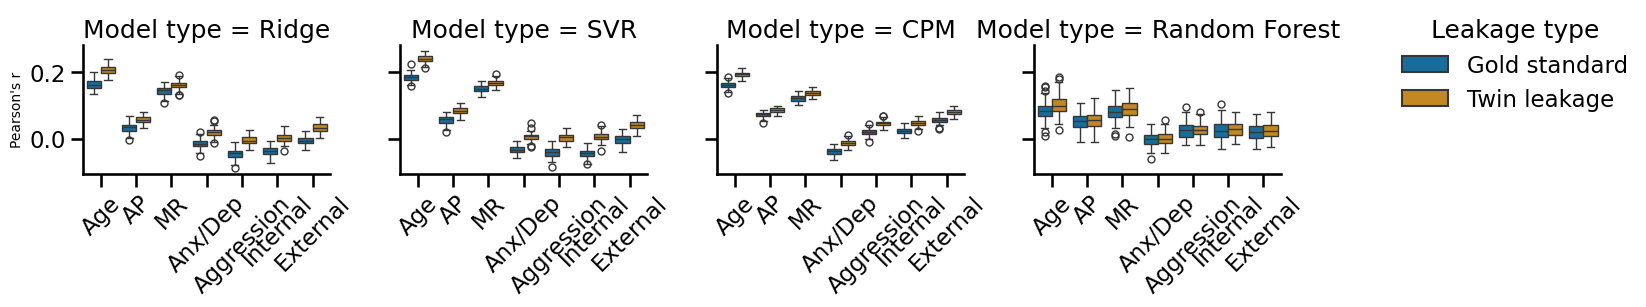

In [ ]:
'''
Plot comparison of twin/no twin leakage across more models/phenotypes (supplemental figure 2)
'''

df_plot = df_results.copy()
pheno_order = ['Age', 'AP', 'MR', 'Anx/Dep', 'Aggression', 'Internal', 'External']
aspect = 1.2
legend_loc = (0.9, 0.975)

# fix attention problems name
df_plot['pheno'] = df_plot['pheno'].replace('Attn', 'AP')

df_plot = df_plot.rename(columns={'leakage_type':'Leakage type', 'model_type':'Model type'})

g = sns.catplot(
    data=df_plot, x='pheno', y='r', hue='Leakage type',
    col='Model type', kind='box',
    order=pheno_order,
    col_order = ['Ridge', 'SVR', 'CPM', 'Random Forest'],
    aspect=aspect, height=2.8, legend=True,
    hue_order = ['Gold standard', 'Twin leakage'],
    palette = sns.color_palette('colorblind')
)
g.set_ylabels("Pearson's r", fontsize=10)
g.set_xlabels("", fontsize=10)
_ = [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
sns.move_legend(g, "upper left", bbox_to_anchor=legend_loc )


In [ ]:
'''
Merge results from models with phenotype similarity data
This data will be used in plot for comparing phenotype similarity and effects of leakage
'''

# calculate difference in mean absolute error between twins and non-twins
df_pheno['mae_percent_diff'] = (df_pheno['all_other_mae'] - df_pheno['all_twin_mae']) \
    / (0.5*(df_pheno['all_other_mae'] + df_pheno['all_twin_mae']) )
df_pheno['mae_ratio'] = df_pheno['all_twin_mae'] / df_pheno['all_other_mae']

# calculate median results and merge
df_results_median_tmp1 = df_results[df_results.leakage_type=='Gold standard'].groupby(['pheno',
                                                                                    'model_type'],
                                                                                   as_index=False).agg({'r':'median'})
df_results_median_tmp2 = df_results[df_results.leakage_type=='Twin leakage'].groupby(['pheno',
                                                                                    'model_type'],
                                                                                   as_index=False).agg({'r':'median'})
df_results_median = df_results_median_tmp1.merge(df_results_median_tmp2, how='left',
                                                left_on=['pheno', 'model_type'], right_on=['pheno', 'model_type'],
                                                suffixes=('_no_leakage', '_leakage'))
df_results_median['r_diff'] = df_results_median['r_leakage'] - df_results_median['r_no_leakage']
df_results_median['r_percent_diff'] = (df_results_median['r_leakage'] - df_results_median['r_no_leakage']) / \
    (0.5*(df_results_median['r_leakage'] + df_results_median['r_no_leakage']))

df_results_median.head()



pheno     model_type  r_no_leakage  r_leakage    r_diff  \
0         Age            CPM      0.161199   0.194122  0.032923   
1         Age  Random Forest      0.083253   0.100284  0.017031   
2         Age          Ridge      0.163752   0.207763  0.044011   
3         Age            SVR      0.185902   0.240840  0.054939   
4  Aggression            CPM      0.021765   0.048235  0.026469   

   r_percent_diff  
0        0.185316  
1        0.185585  
2        0.236927  
3        0.257479  
4        0.756266

In [ ]:
# merge to add in median results
df_results_pheno_merged = df_results_median.merge(df_pheno, how='left', left_on=['pheno'], right_on=['pheno'])
df_results_pheno_merged = df_results_pheno_merged.rename(columns={'model_type_no_leakage':'model_type'})
df_results_pheno_merged.head()

pheno     model_type  r_no_leakage  r_leakage    r_diff  \
0         Age            CPM      0.161199   0.194122  0.032923   
1         Age  Random Forest      0.083253   0.100284  0.017031   
2         Age          Ridge      0.163752   0.207763  0.044011   
3         Age            SVR      0.185902   0.240840  0.054939   
4  Aggression            CPM      0.021765   0.048235  0.026469   

   r_percent_diff  all_twin_mae  all_other_mae  mae_percent_diff  mae_ratio  
0        0.185316      0.008881       0.676668          1.948182   0.013125  
1        0.185585      0.008881       0.676668          1.948182   0.013125  
2        0.236927      0.008881       0.676668          1.948182   0.013125  
3        0.257479      0.008881       0.676668          1.948182   0.013125  
4        0.756266      2.278863       3.525395          0.429523   0.646414

Text(0.5, 1.0, 'CPM')

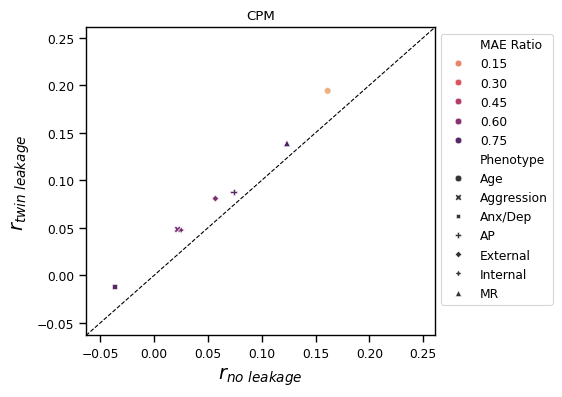

In [ ]:
'''
Plot for effects of leakage compared by phenotype similarity
Change the model type below ('Ridge', 'CPM', 'SVR', 'Random Forest')
Supplementary Figure 3
'''

plot_model='CPM'


sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4.5, 4))
df_plot = df_results_pheno_merged[df_results_pheno_merged.model_type==plot_model]
df_plot = df_plot.rename(columns={'mae_ratio':'MAE Ratio', 'pheno':'Phenotype'})  # rename columns for plot

# change attention problems name
df_plot['Phenotype'] = df_plot['Phenotype'].replace('Attn', 'AP')

min_ax_lim = np.min([df_results_pheno_merged.r_no_leakage.min(), df_results_pheno_merged.r_leakage.min()]) - 0.02
max_ax_lim = np.max([df_results_pheno_merged.r_no_leakage.max(), df_results_pheno_merged.r_leakage.max()]) + 0.02

ax.plot([min_ax_lim, max_ax_lim], [min_ax_lim, max_ax_lim], linestyle='--', color='black', lw=0.8)


sns.scatterplot(data=df_plot, x='r_no_leakage', y='r_leakage',
                hue='MAE Ratio', style='Phenotype', ax=ax,
                palette=sns.color_palette('flare', as_cmap=True) )

ax.legend(bbox_to_anchor=(1, 1))

ax.set_xlim([min_ax_lim, max_ax_lim])
ax.set_ylim([min_ax_lim, max_ax_lim])
ax.set_xlabel('$r_{no \ leakage}$', fontsize=14)
ax.set_ylabel('$r_{twin \ leakage}$', fontsize=14)
ax.set_title(plot_model)


# Supplementary Figure 4

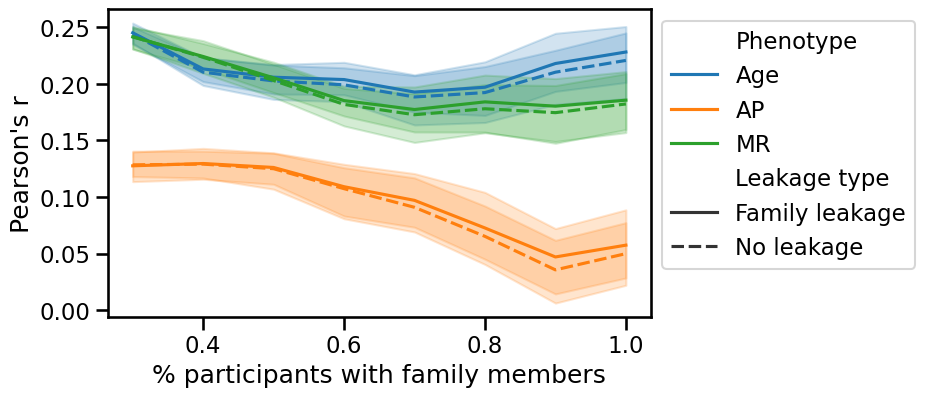

In [ ]:
'''
Plot for family percentage simulation
'''
# load results
df_results = df_plot = pd.read_excel(github_file_link, sheet_name='figure_s4')

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(7, 4))

# clean up dataframe so plot labels look better
df_plot = df_results.rename(columns={'pheno':'Phenotype', 'leak':'Leakage type'})
df_plot['Leakage type'] = df_plot['Leakage type'].replace(True, 'Family leakage').replace(False, 'No leakage')
df_plot['Phenotype'] = df_plot['Phenotype'].replace('age', 'Age').replace('attn', 'AP').replace('mr', 'MR')


sns.lineplot(data=df_plot, x='family_percentage', y='r',
             hue='Phenotype', style='Leakage type', errorbar='pi',
            legend='full')

ax.set_xlabel('% participants with family members')
ax.set_ylabel("Pearson's r")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Supplementary Figure 7



In [ ]:
# load results
df_coef = pd.read_excel(github_file_link, sheet_name='figure_s7')

# convert strings to np arrays
cmat_mean = []
for iloc in range(len(df_coef)):
  cmat_lines = df_coef.iloc[iloc, :].cmat_mean.split('[')
  cmat_lines = [l.replace('\n', '').replace(']', '').replace('[', '').strip() for l in cmat_lines]
  cmat_lines = [l for l in cmat_lines if l!='']

  cmat_lines_list = [[float(l) for l in cmat_line.split(' ') if l!=''] for cmat_line in cmat_lines]
  cmat_mean.append(np.array(cmat_lines_list))

df_coef['cmat_mean'] = cmat_mean

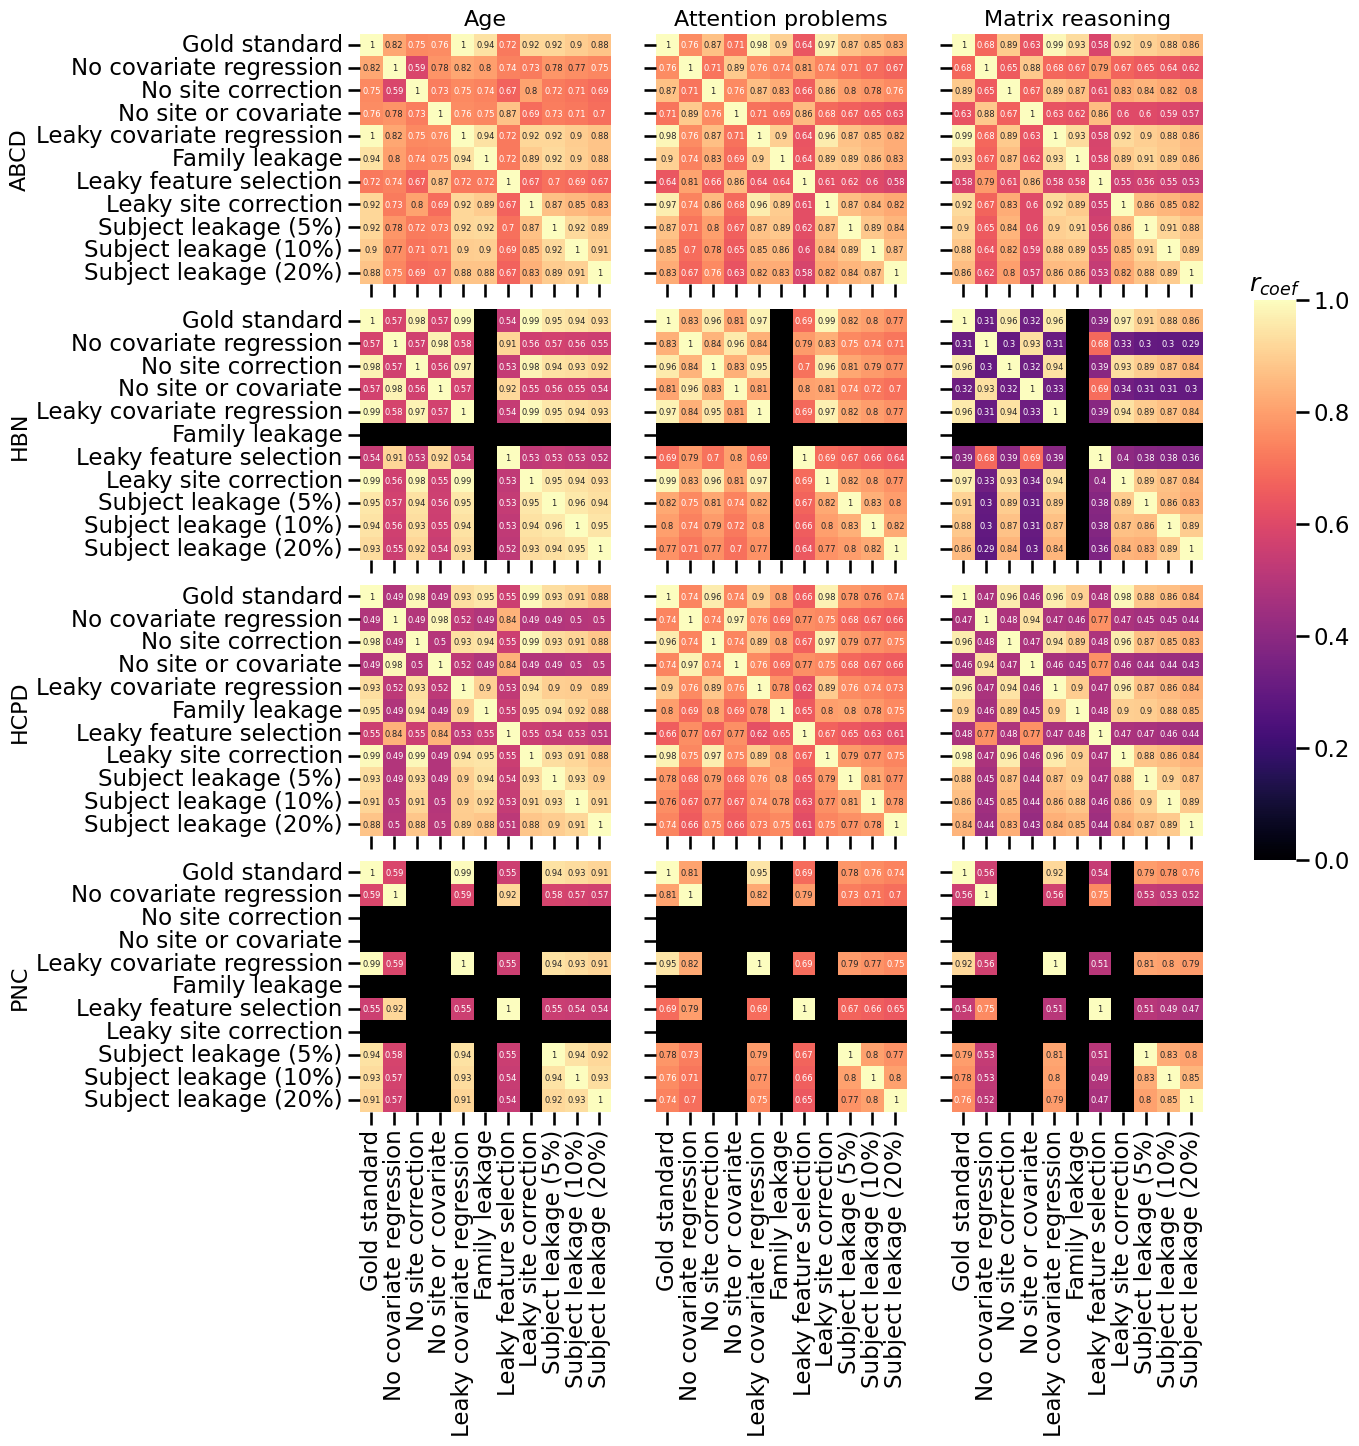

In [ ]:
# rename pheno vars
df_coef['pheno'] = df_coef['pheno'].replace({'age':'Age',
                                            'ap':'Attention problems',
                                            'mr':'Matrix reasoning'})

# rename leakage_types
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}
leakage_types_load = ['gold', 'gold_minus_covars', 'gold_minus_site',
      'gold_minus_site_covars',
      'leak_covars', 'leak_family', 'leak_feature',
      'leak_site', 'leak_subj_5', 'leak_subj_10',
      'leak_subj_20']
leakage_types_plot = [rename_dict[l] for l in leakage_types_load]

datasets = ['abcd', 'hbn', 'hcpd', 'pnc']
pheno = ['Age', 'Attention problems', 'Matrix reasoning']

fig, axes = plt.subplots(nrows=len(datasets), ncols=len(pheno),
                        figsize=(14, 14),
                        sharex=True, sharey=True)

cbar_ax = fig.add_axes([.85, .29, .03, .4])

# update axis labeling
for i in range(len(datasets)):
    for j in range(len(pheno)):

        ax = axes[i, j]

        # restrict dataframe
        df_plot = df_coef[(df_coef.dataset==datasets[i]) &
                         (df_coef.pheno==pheno[j])].reset_index(drop=True)

        # heatmap plot
        h = sns.heatmap(df_plot.iloc[0, :].cmat_mean, ax=ax,
                    vmin=0, vmax=1,
                   cbar=((i==0)&(j==0)),
                        cbar_ax=None if ((i!=0)|(j!=0)) else cbar_ax,
                   square=True,
                   annot=True, fmt='.2g', annot_kws={"size": 6},
                   cmap=sns.color_palette("magma", as_cmap=True),
                       yticklabels=leakage_types_plot,
                       xticklabels=leakage_types_plot)
        ax.set_facecolor('black')

        # title for rows
        if i==0:
            ax.set_title(pheno[j], fontsize=16)
        if j==0:
            ax.set_ylabel(datasets[i].upper(), fontsize=16)



cbar_ax.set_title('$r_{coef}$')
fig.subplots_adjust(hspace=0.1, wspace=-0.4)


# Supplementary Figure 8

<ipython-input-28-fcec775ea57c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)
<ipython-input-28-fcec775ea57c>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='leakage_type', y=plot_type, ax=axs[row_idx, col_idx],
<ipython-input-28-fcec775ea57c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

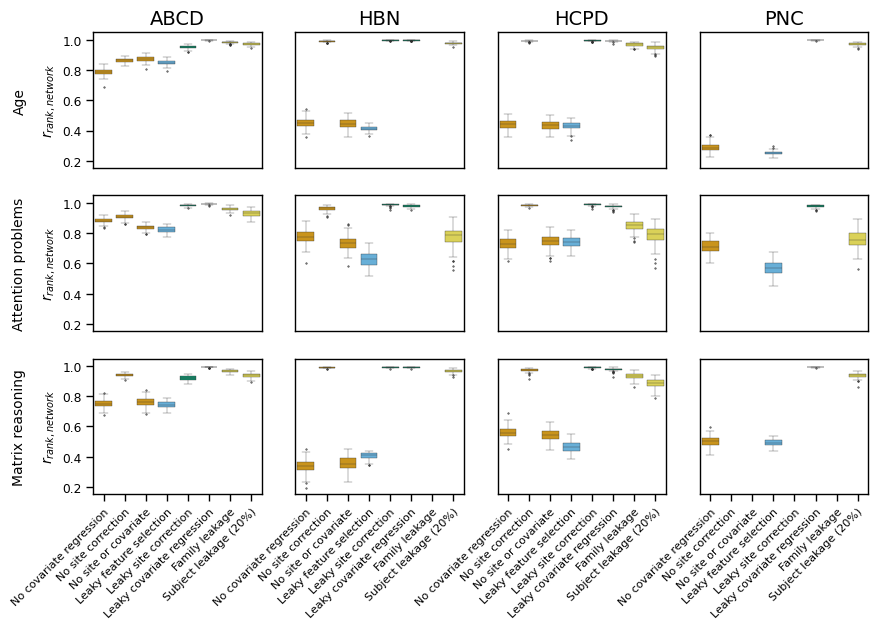

In [ ]:
# plots for coefficients, can either be r_coef or spearman rank between network counts for feature selection

# load data
df_all = pd.read_excel(github_file_link, sheet_name='figure_8')

coloring_type = 'leakage_family'  # '' or 'leakage_family', how to color boxes

plot_type = 'spearman_network_feat'  # r_coef, spearman_network_feat

pheno_all = ['age', 'ap', 'mr']
dataset_all = ['abcd', 'hbn', 'hcpd', 'pnc']
sns.set_context('paper')

# sort it for right ordering
all_leakage_types = [k for k in sort_dict.keys()]


npheno = len(pheno_all)
ndataset = len(dataset_all)
fig, axs = plt.subplots(nrows=npheno, ncols=ndataset, figsize=(10, 6))
for row_idx, pheno in enumerate(pheno_all):
    for col_idx, dataset in enumerate(dataset_all):

        df_plot = df_all[(df_all.pheno==pheno) & (df_all.dataset==dataset)]

        # rename columns
        df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)



        leakage_types = ['No covariate regression', 'No site correction',
                         'No site or covariate', 'Leaky feature selection',
                        'Leaky site correction', 'Leaky covariate regression',
                        'Family leakage', 'Subject leakage (20%)']

        # restrict plot df to just leakage types of interest
        df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

        df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

        ###################################### Actual plotting ######################################
        if coloring_type=='leakage_family':
            # updated palette by leakage type:
            # see https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
            pal = ['#E69F00', '#E69F00', '#E69F00',
                  '#56B4E9',
                  '#009E73', '#009E73',
                  '#F0E442','#F0E442']
        else:
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

        # new way: boxplot
        sns.boxplot(data=df_plot, x='leakage_type', y=plot_type, ax=axs[row_idx, col_idx],
                   palette=pal, order=leakage_types,
                    linewidth=0.25, fliersize=0.5)

        if plot_type=='spearman_network_feat':
            axs[row_idx, col_idx].set_ylim([0.15, 1.05])
        else:
            axs[row_idx, col_idx].set_ylim([0.25, 1.05])

        if row_idx == (npheno-1):
            axs[row_idx, col_idx].set_xlabel('Leakage type')
            axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45,
                                                  ha='right', fontsize=8, rotation_mode="anchor")
            axs[row_idx, col_idx].set_xlabel('')
        else:
            axs[row_idx, col_idx].set_xlabel('')
            axs[row_idx, col_idx].set_xticks([])

        if row_idx==0:
            axs[row_idx, col_idx].set_title(dataset.upper(), fontsize=14)

        if col_idx == 0:
            if plot_type=='spearman_network_feat':
                axs[row_idx, col_idx].set_ylabel('$r_{rank,network}$', fontsize=10)
            elif plot_type=='r_coef':
                axs[row_idx, col_idx].set_ylabel('$r_{coef}$', fontsize=10)

            # add y label
            if pheno=='ap':
                y_lab_bigtext = 'Attention problems'
            elif pheno=='age':
                y_lab_bigtext = 'Age'
            elif pheno=='mr':
                y_lab_bigtext = 'Matrix reasoning'

            # adjust y label location based on which plot type
            if plot_type=='spearman_network_feat':
                yloc = 0.6
            else:
                yloc = 0.65

            axs[row_idx, col_idx].text(-4, yloc, y_lab_bigtext,
                                       rotation=90, ha='center', va='center',fontsize=10)
        else:
            axs[row_idx, col_idx].set_ylabel('')
            axs[row_idx, col_idx].set_yticks([])



# Supplementary Figure 9

<ipython-input-31-84f0663fc034>:8: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.catplot(


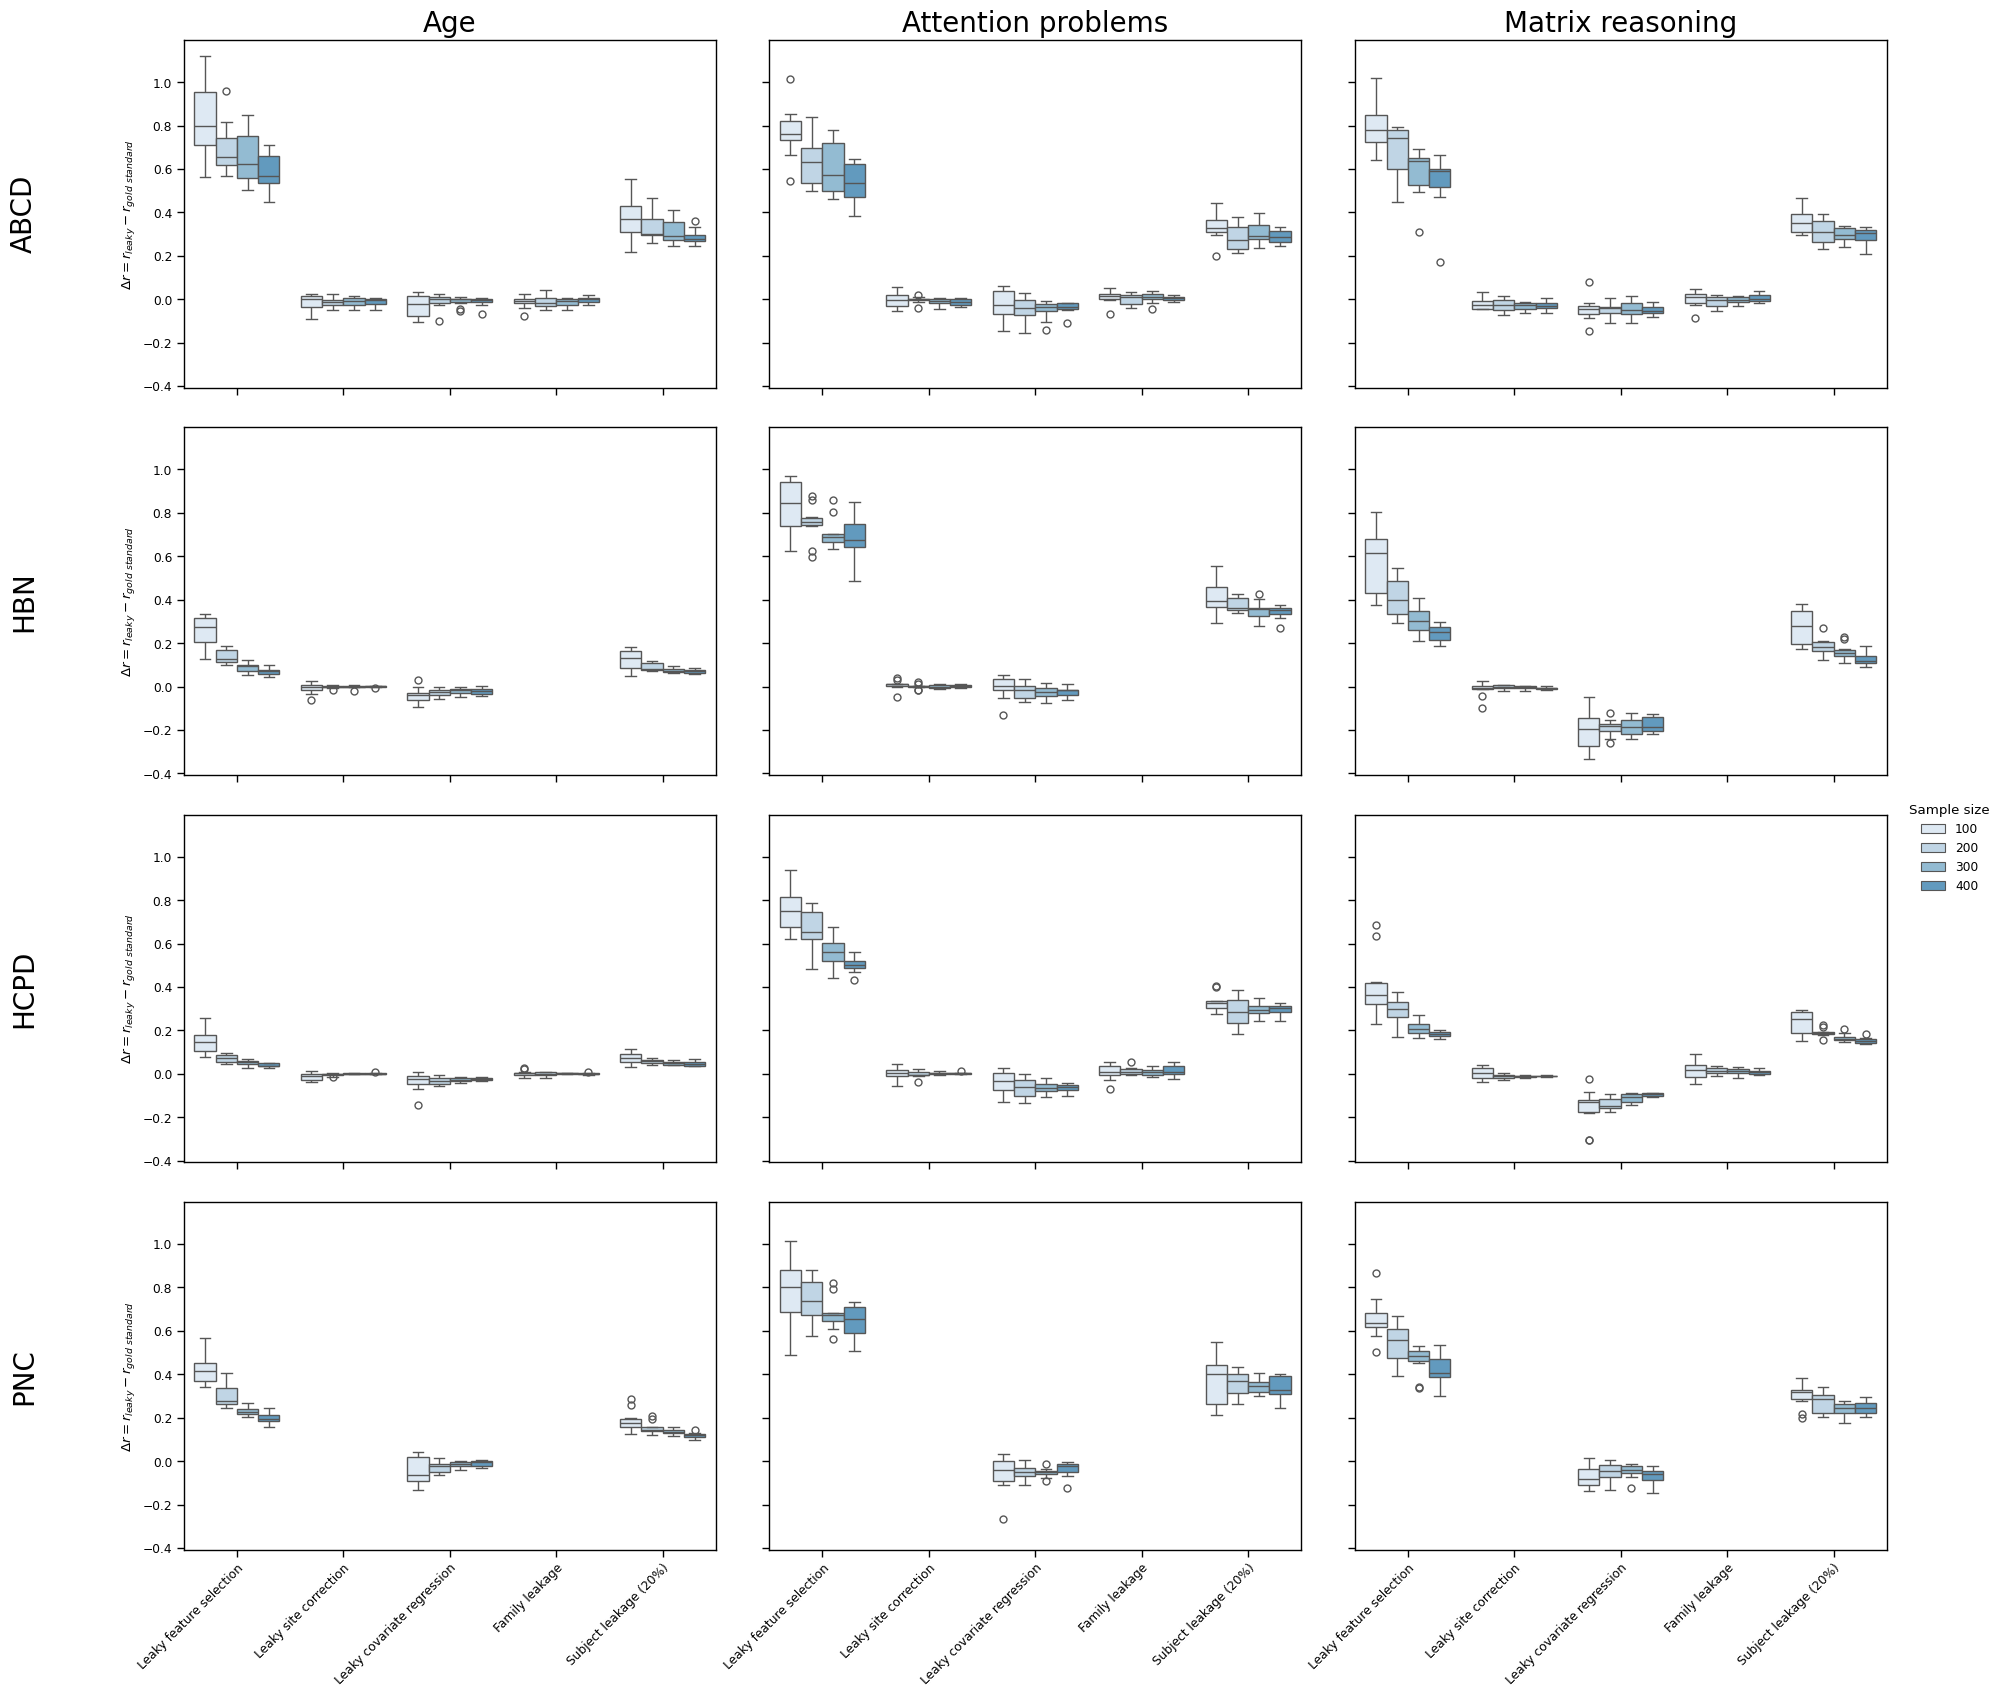

In [ ]:
'''
Plot across MEDIAN of k-fold and resample seeds
'''

df_plot = pd.read_excel(github_file_link, sheet_name='figure_s9')

# for pheno in cols
g = sns.catplot(
    data=df_plot, x='leakage_type', y='r_diff_med', hue='sample_size',
    col='pheno', row='dataset',
    kind='box',
    palette=sns.color_palette("Blues"),
    height=4, aspect=1.5,
    order=leakage_types,
    col_order=['Age', 'Attention problems', 'Matrix reasoning'],
    row_order=['abcd', 'hbn', 'hcpd', 'pnc']
)

leakage_types = list(df_plot.leakage_type.unique())
g.set_xticklabels(leakage_types, rotation=45, ha='right', rotation_mode='anchor')
g.set_axis_labels('', '$\Delta r = r_{leaky} - r_{gold \ standard}$')

# legend title
g.legend.set_title('Sample size')

# decrease width space (hspace for height)
g.fig.subplots_adjust(wspace=0.1)


# update axis labeling
for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip().replace('pheno = ', ''), fontsize=20)
        else:
            axes_col.set_title('')


        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(ylabel)

            axes_col.text(-0.3, 0.5, row.strip().replace('dataset = ', '').upper(),
                          fontsize=20, transform=axes_col.transAxes, rotation=90,
               horizontalalignment = 'center', verticalalignment='center')

# add box around axes
for ax in g.axes.flatten(): # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)

plt.show()


# Supplementary Figures 10 and 12

Plots for CPM and SVR results

In [ ]:
# read in and add new columns
model_type = 'svr'  # cpm, svr

if model_type=='cpm':
    df_all = pd.read_excel(github_file_link, sheet_name='figure_s11')

elif model_type=='svr':
    df_all = pd.read_excel(github_file_link, sheet_name='figure_s10')


# add in grouped (e.g., mean by leakage type) information
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                      right_on=['leakage_type', 'dataset', 'pheno'])
# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)


df_all = df_all.sort_values('leakage_type')

<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


leak_family


<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_minus_site
gold_minus_site_covars
leak_site
leak_family


<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


leak_family


<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


gold_minus_site
gold_minus_site_covars
leak_site
leak_family


<ipython-input-33-8ebdc7b71971>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


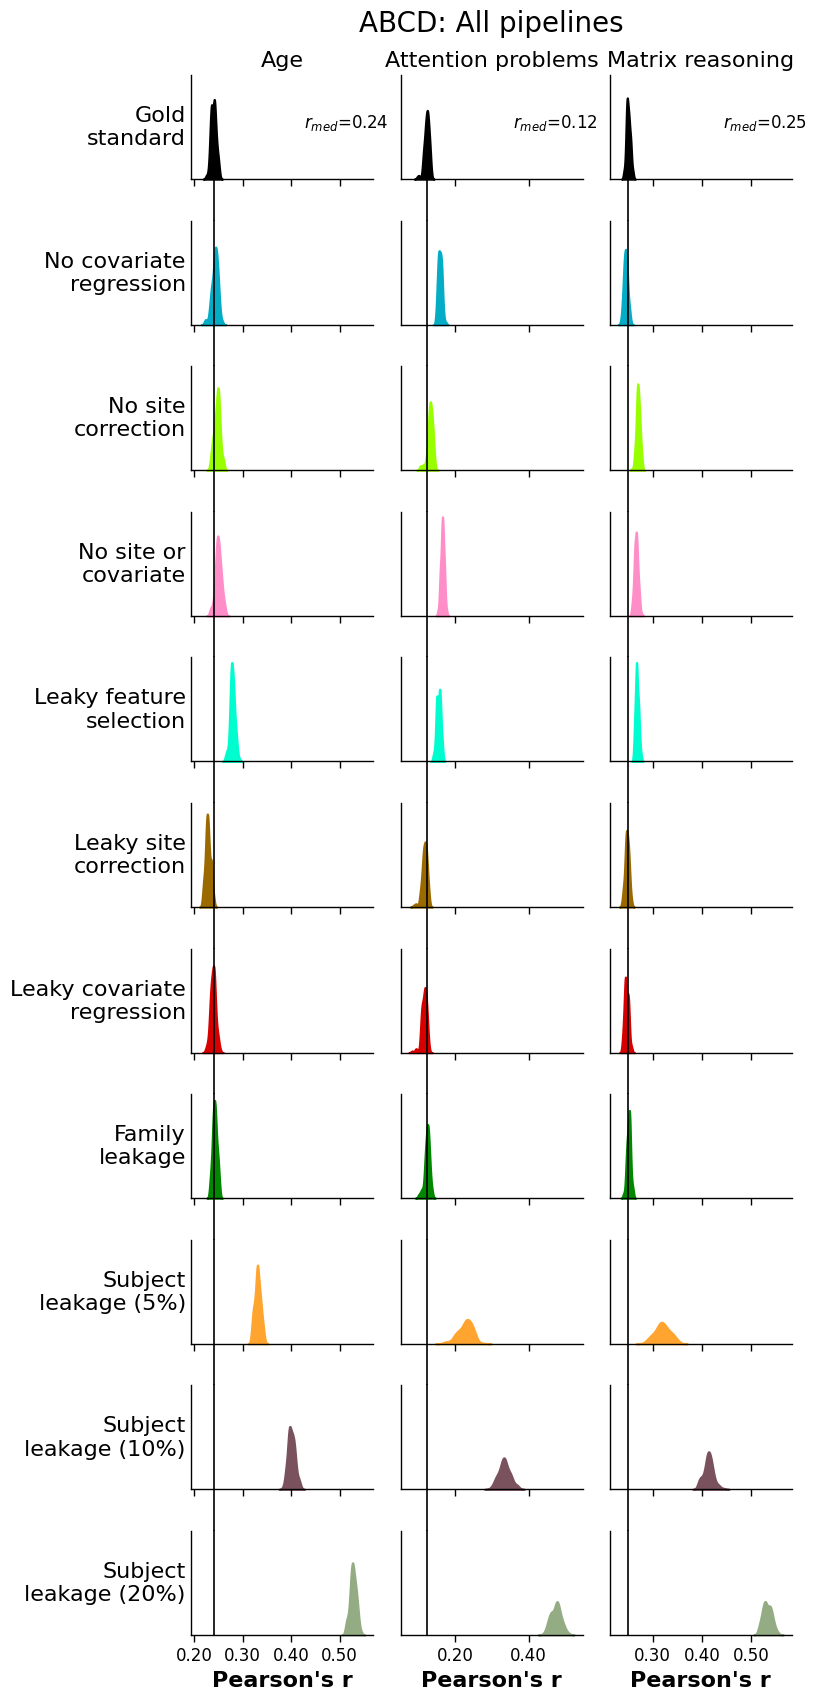

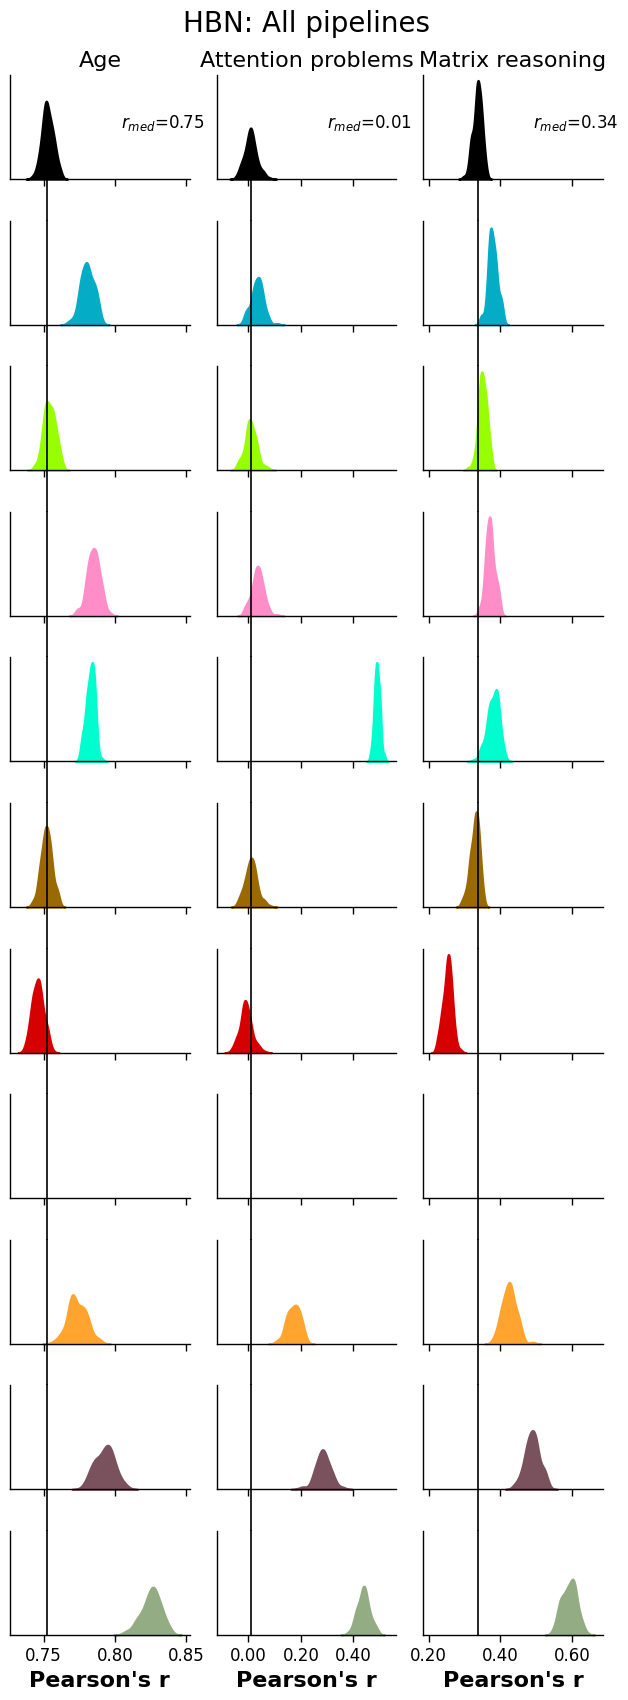

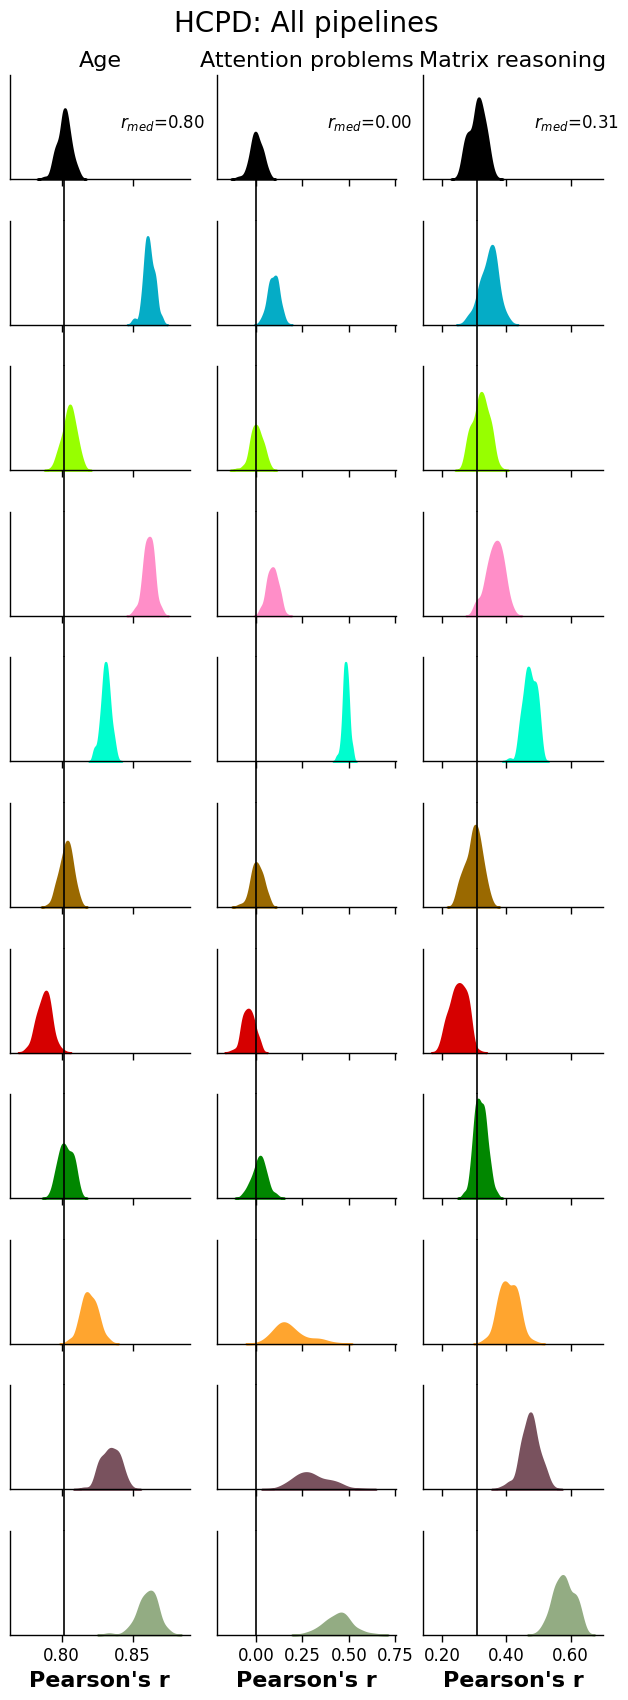

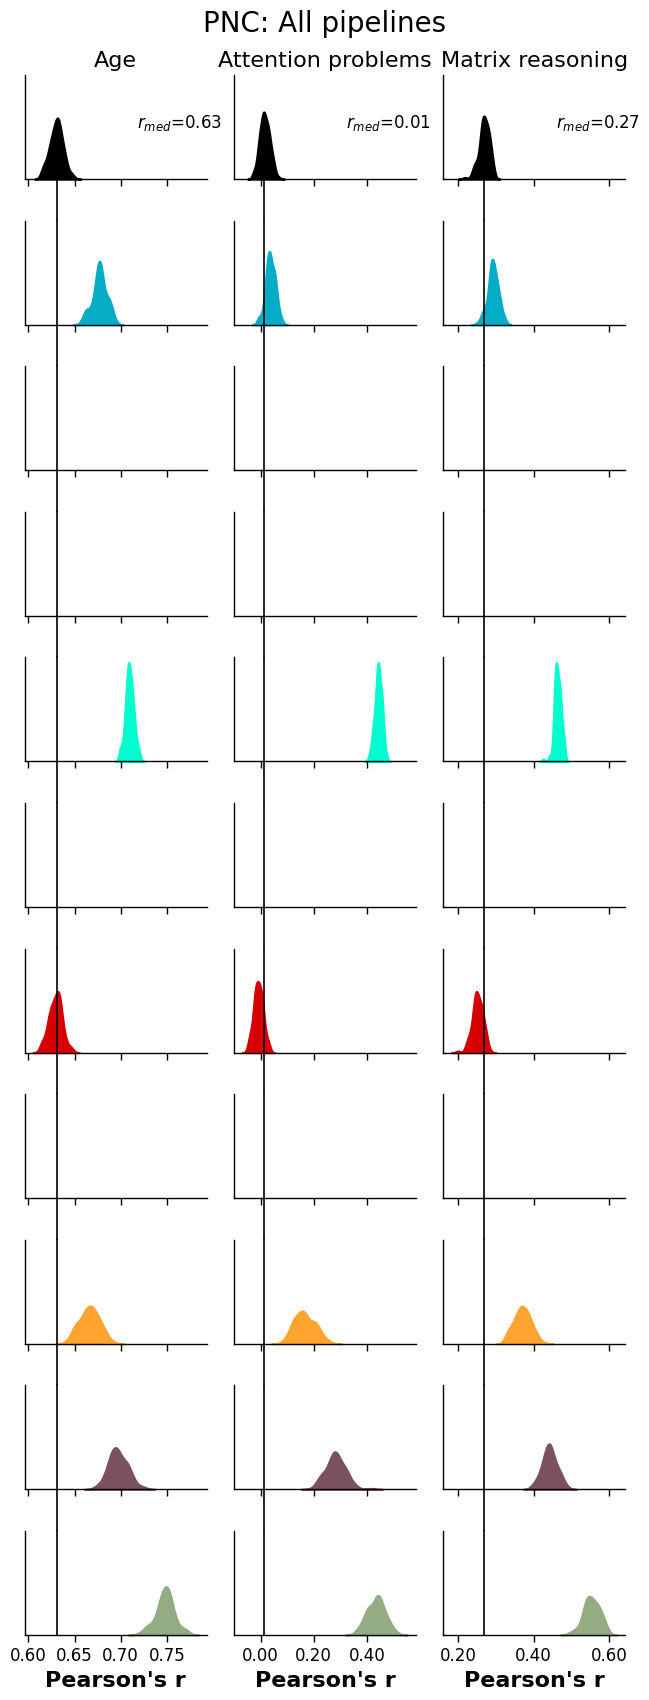

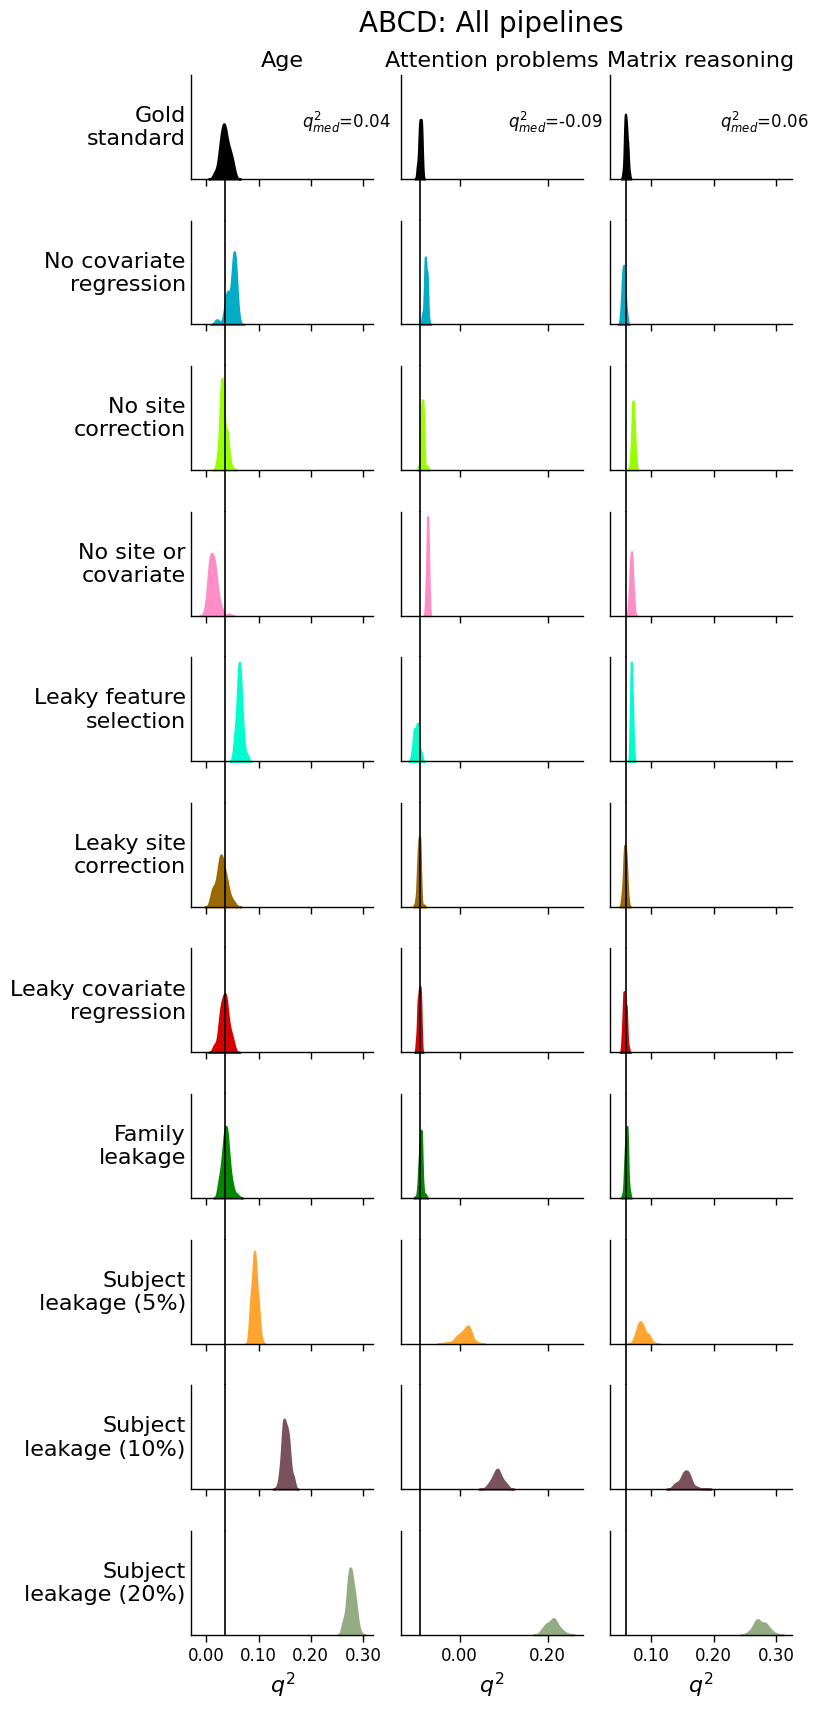

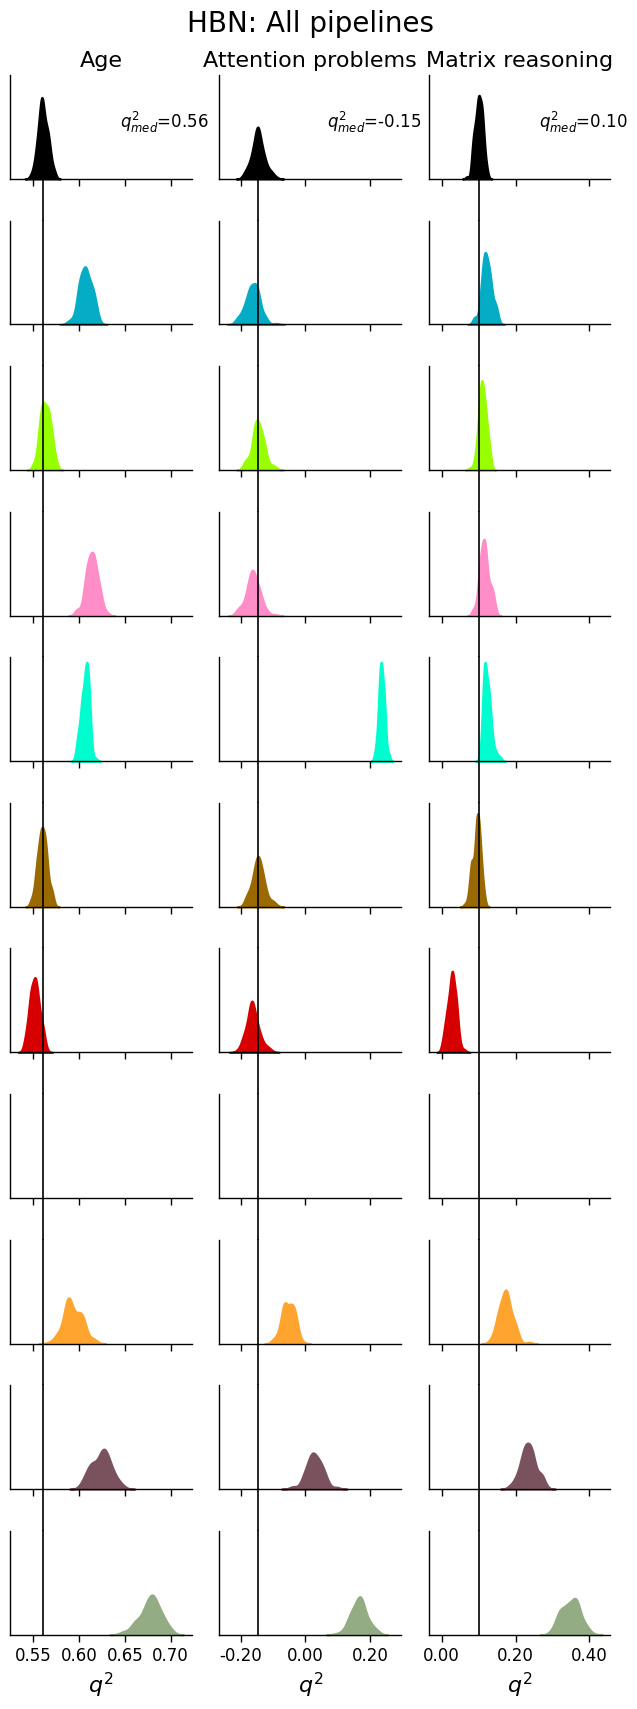

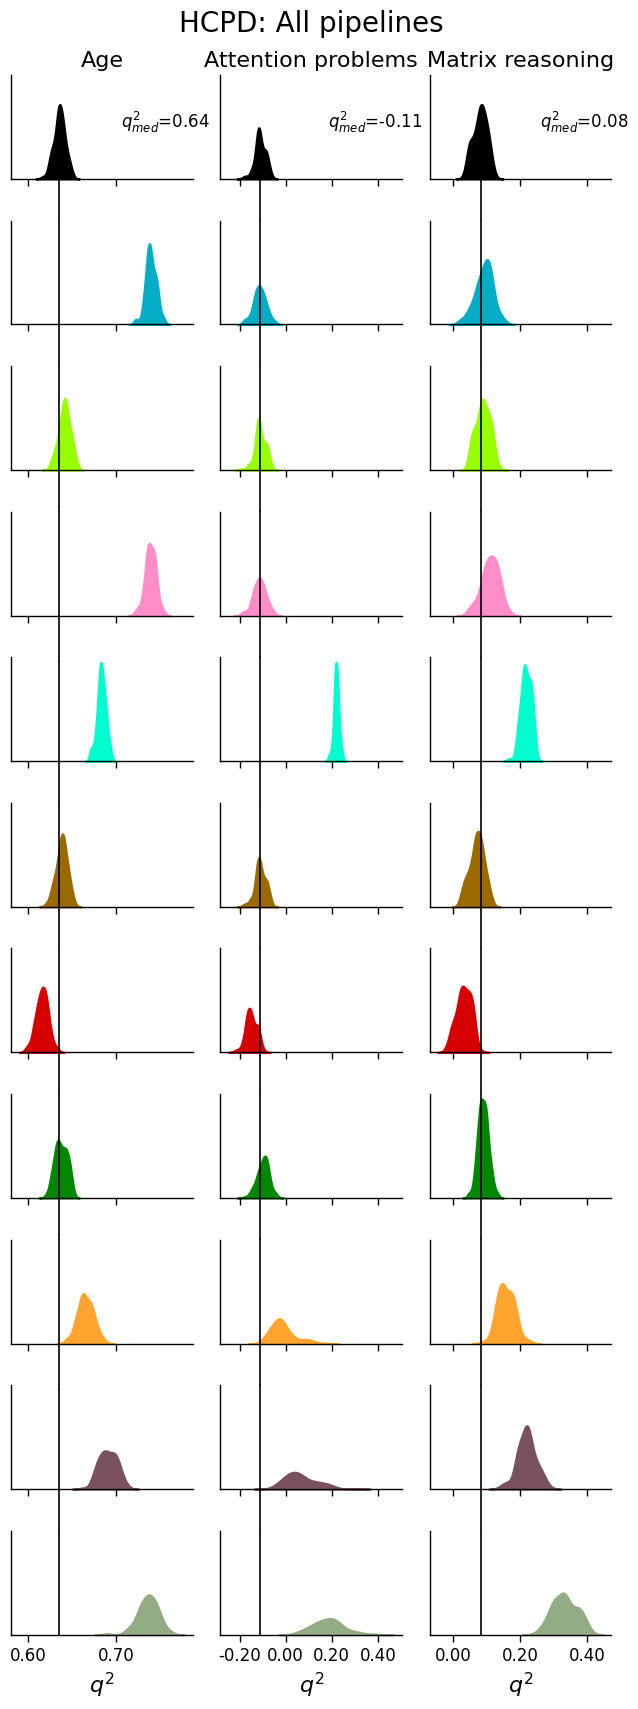

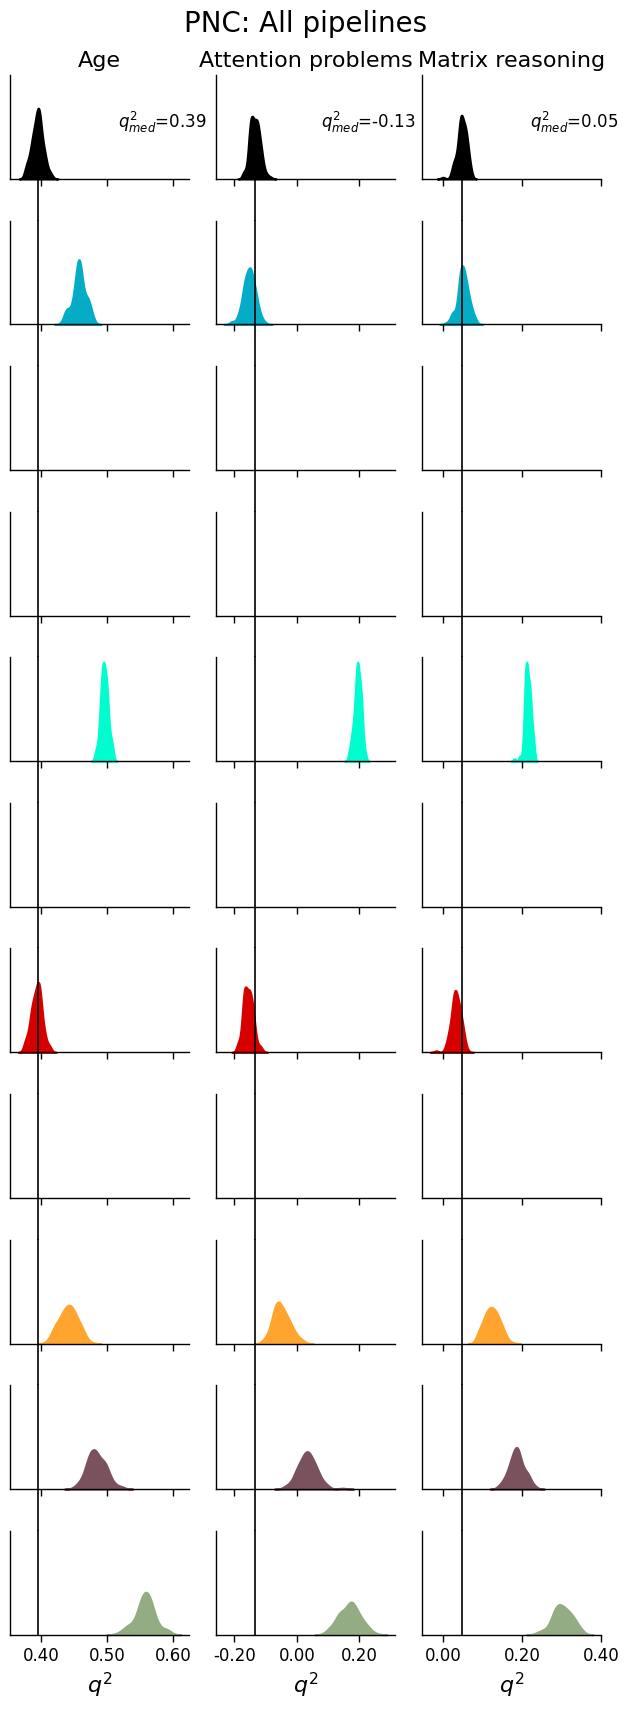

In [ ]:
'''
Plots for any combination of dataset/phenotype
'''
sns.set_context('paper')
for r_or_q2 in ['r', 'q2']:
    for dataset in ['abcd', 'hbn', 'hcpd', 'pnc']:
        for leakage_cat in ['All pipelines']:

            '''
            Copy below for all
                            'All pipelines',
                            'Feature leakage',
                            'Subject-level leakage',
                            'Covariate-related leakage',
                           'Non-leaky analysis choices'
            '''


            df_plot = df_all[(df_all.dataset==dataset)]

            # sort it for right ordering
            sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3,
                         'leak_feature':4, 'leak_site':5, 'leak_covars':6, 'leak_family':7,
                        'leak_subj_5':8, 'leak_subj_10':9, 'leak_subj_20':10}

            # add in missing keys
            all_leakage_types = [k for k in sort_dict.keys()]
            for k in sort_dict.keys():
                if k not in df_plot.leakage_type.unique():
                    print(k)
                    df_tmp = pd.DataFrame(np.nan, index=[0], columns=df_plot.keys())
                    df_tmp['dataset'] = dataset
                    df_tmp['pheno'] = np.nan
                    df_tmp['leakage_type'] = k
                    df_tmp['r'] = df_plot.r.mean()
                    df_tmp['med_r'] = np.nan
                    df_tmp['q2'] = df_plot.q2.mean()
                    df_tmp['med_q2'] = np.nan
                    df_plot = pd.concat([df_plot, df_tmp])

            # sort it
            df_plot = df_plot.reset_index(drop=True)
            df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


            # rename
            rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
                           'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
                           'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
                           'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
                           'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
                        'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
                           'leak_subj_20':'Subject leakage (20%)'}
            df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)


            # color palette dictionary based on names
            pal_all = ['black']
            np.random.seed(4)
            cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
            color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity

            if leakage_cat=='Feature leakage':
                leakage_types = ['Gold standard', 'Leaky feature selection']
            elif leakage_cat=='Subject-level leakage':
                leakage_types = ['Gold standard', 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)']
            elif leakage_cat=='Covariate-related leakage':
                leakage_types = ['Gold standard',
                                'Leaky site correction', 'Leaky covariate regression']
            elif leakage_cat=='Non-leaky analysis choices':
                leakage_types = ['Gold standard', 'No covariate regression', 'No site correction',
                                 'No site or covariate']
            elif leakage_cat=='All pipelines':
                leakage_types = ['Gold standard',
                                 'No covariate regression', 'No site correction',
                                 'No site or covariate',
                                 'Leaky feature selection',
                                'Leaky site correction', 'Leaky covariate regression',
                                 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)'

                                ]


            # restrict plot df to just leakage types of interest
            df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

            df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

            ###################################### Actual plotting ######################################
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

            # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
            plot_aspect = 1.5
            plot_height = 1.5
            fontsize=16

            g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                              aspect=plot_aspect, height=plot_height,
                              palette=pal,
                              col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                              row_order=leakage_types,
                              sharex='col', sharey='col')

            # then we add the densities kdeplots f
            g.map(sns.kdeplot, r_or_q2,
                  bw_adjust=1, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)

            # adjust plot spacing
            g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


            for row_idx, ax_col in enumerate(g.axes):
                nrows = len(g.axes)
                for col_idx, ax in enumerate(ax_col):

                    # if in first column and relevant datasets, set ylabel
                    if (col_idx==0) & (dataset=='abcd'):
                        leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                        leakage_type_str = two_line_text(leakage_type_str)
                        ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

                    else:
                        ax.set_ylabel('')

                    # if in first row, set title
                    pheno_str = ax.title.get_text().split('=')[-1].strip()
                    if row_idx==0:
                        ax.set_title(pheno_str, fontsize=fontsize)
                    else:
                        ax.set_title('')

                    # other formatting specifications
                    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
                    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax.set_yticks([])

                    # for last row
                    if r_or_q2=='r':
                        xlab = "Pearson's r"
                    else:
                        xlab = "$q^2$"
                    ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

                    # vertical line - the mean doesn't do anything since it's one value anyways
                    gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                         (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
                    if row_idx==0:
                        ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
                    elif row_idx==(nrows-1):
                        ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
                    else:
                        ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

                    # add text to axis with median r (gold_value)
                    if row_idx==0:
                        if leakage_cat=='Covariate-related leakage':
                            xloc = 0.175
                            yloc = 0.55
                        elif leakage_cat=='All pipelines':
                            xloc = 0.85
                            yloc = 0.55
                        else:
                            xloc = 0.89
                            yloc = 0.55

                        if r_or_q2=='r':
                            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)
                        elif r_or_q2=='q2':
                            ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)


            # add in dataset title
            mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
            g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), leakage_cat),
                           ha='center',
                           va='top',
                           fontsize=fontsize+4,
                           fontweight=20,
                           x=mid, y=1.02)

# Supplementary Figure 14

DTI data with q2 evaluation

In [ ]:
# load data
df_all =  pd.read_excel(github_file_link, sheet_name='figure_s14')

# group data to get median results
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
# merge in mean/median results
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                      right_on=['leakage_type', 'dataset', 'pheno'])

# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)

# sort by leakage type
df_all = df_all.sort_values('leakage_type')

<ipython-input-35-7dd7d4459749>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


Text(0.5159259129362682, 1.02, 'HCPD (DTI): All pipelines')

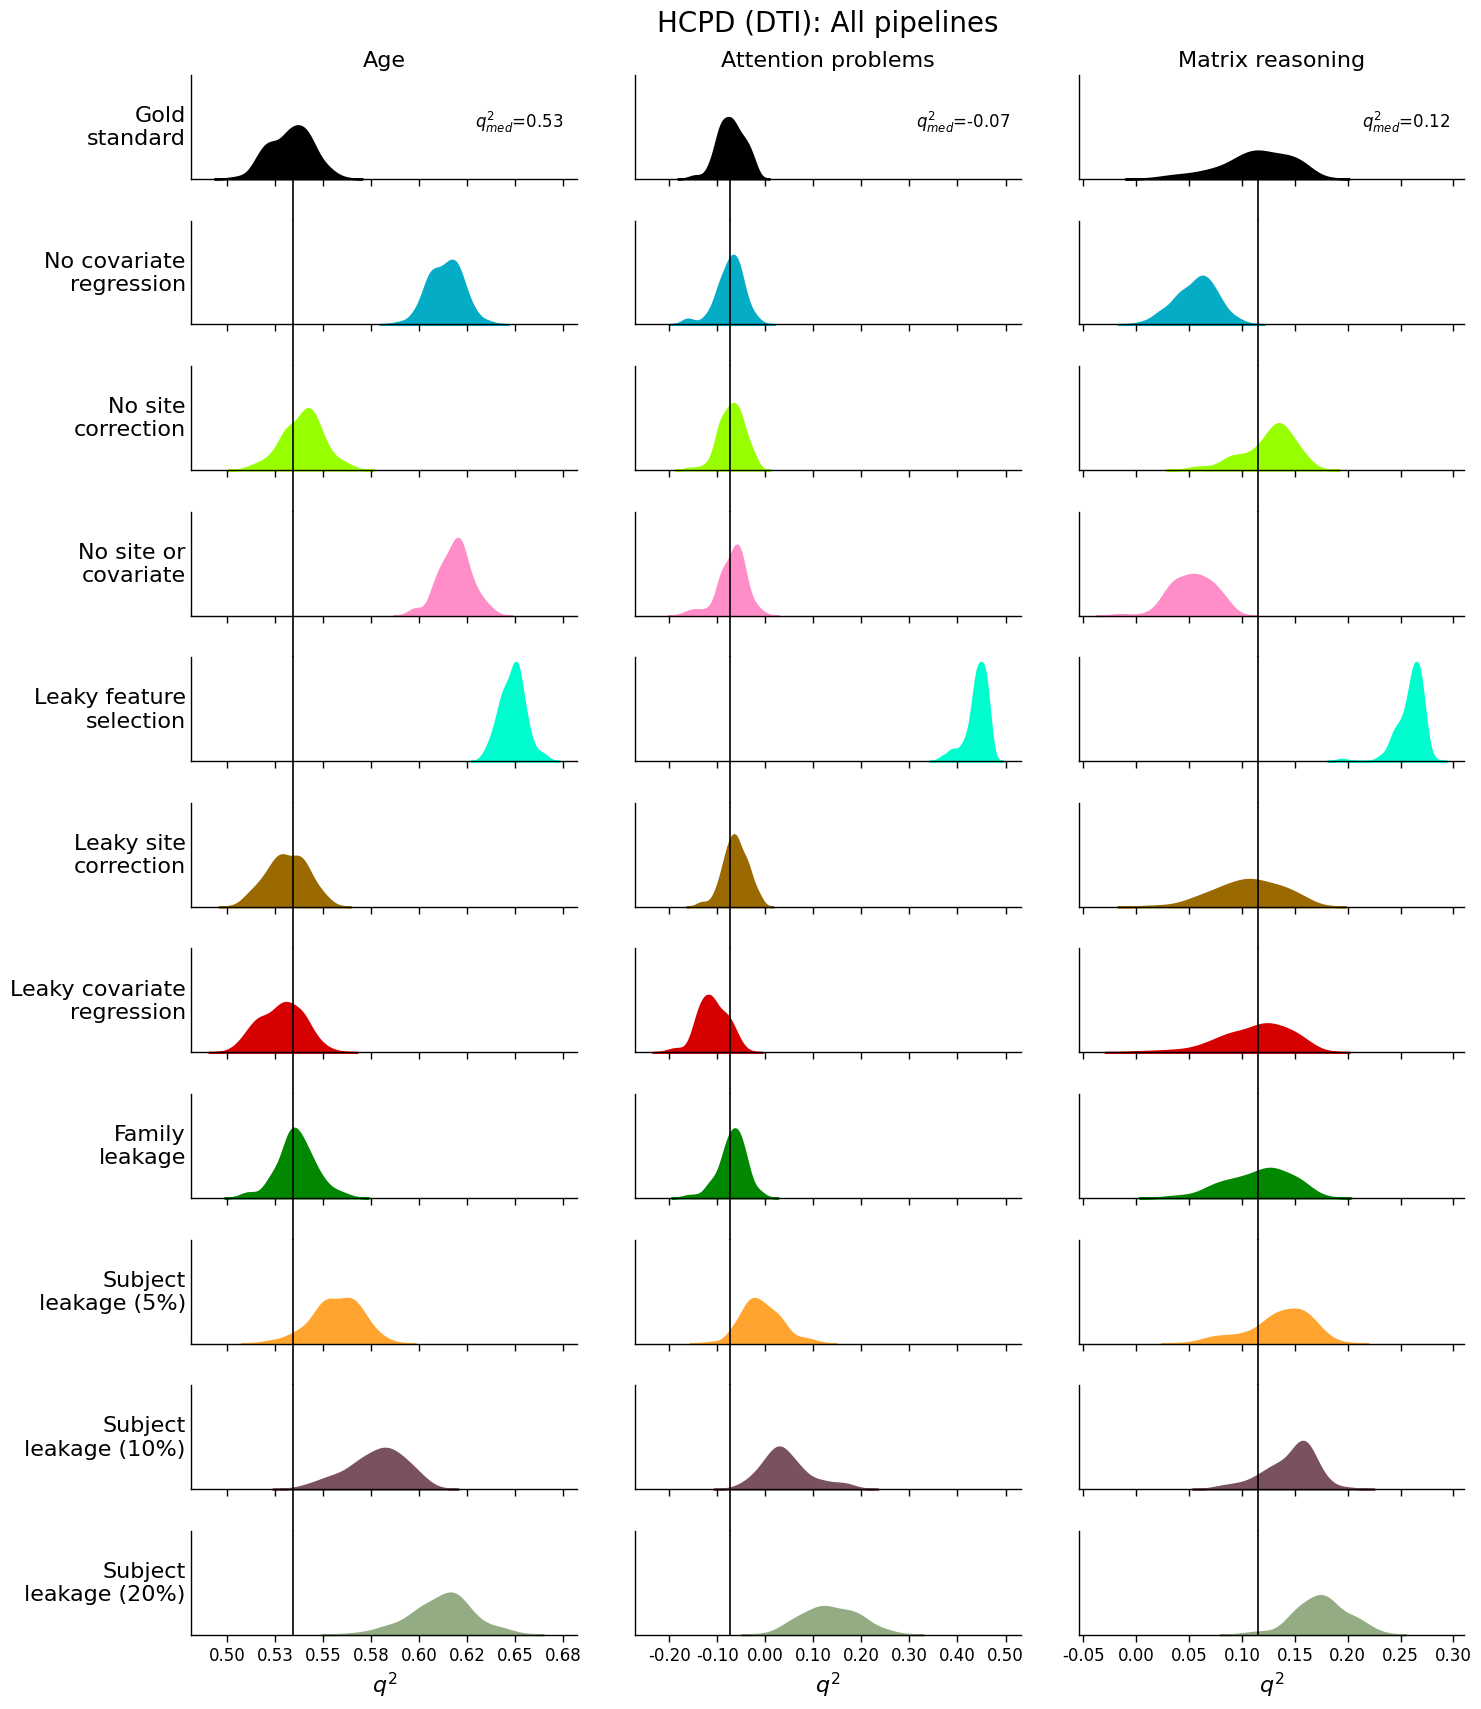

In [ ]:
'''
Plots for DTI results, set r (Figure 10) and q2 (Supplementary Figure 14) below
'''

# rename dataset
df_all['dataset'] = df_all['dataset'].replace('hcpddti', 'HCPD (DTI)')

r_or_q2 = 'q2'  # 'r' 'q2'
dataset = 'HCPD (DTI)'

# restrict to dti data
df_plot = df_all[(df_all.dataset==dataset)]

# sort it by leakage type
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


# rename leakage types
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
                'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
                'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
                'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
                'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
                'leak_subj_20':'Subject leakage (20%)'}
df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)



# color palette dictionary based on names
pal_all = ['black']
np.random.seed(4)
cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity

leakage_types = ['Gold standard',
                  'No covariate regression', 'No site correction',
                  'No site or covariate',
                  'Leaky feature selection',
                'Leaky site correction', 'Leaky covariate regression',
                  'Family leakage', 'Subject leakage (5%)',
                'Subject leakage (10%)', 'Subject leakage (20%)'

                ]


# restrict plot df to just leakage types of interest
df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                            'mr':'Matrix reasoning',
                                            'age':'Age'})

###################################### Actual plotting ######################################
# palette based on smaller dataframe
pal = [pal_dict[l] for l in leakage_types]

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
plot_aspect = 3
plot_height = 1.5
fontsize = 16

g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                  aspect=plot_aspect, height=plot_height,
                  palette=pal,
                  col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                  row_order=leakage_types,
                  sharex='col', sharey='col')

# then we add the densities kdeplots f
g.map(sns.kdeplot, r_or_q2,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# adjust plot spacing
g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


for row_idx, ax_col in enumerate(g.axes):
    nrows = len(g.axes)
    for col_idx, ax in enumerate(ax_col):

        # if in first column and relevant datasets, set ylabel
        if (col_idx==0):
            leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
            leakage_type_str = two_line_text(leakage_type_str)
            ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

        else:
            ax.set_ylabel('')

        # if in first row, set title
        pheno_str = ax.title.get_text().split('=')[-1].strip()
        if row_idx==0:
            ax.set_title(pheno_str, fontsize=fontsize)
        else:
            ax.set_title('')

        # other formatting specifications
        ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_yticks([])

        # for last row
        if r_or_q2=='r':
            xlab = "Pearson's r"
        else:
            xlab = "$q^2$"
        ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

        # vertical line - the mean doesn't do anything since it's one value anyways
        gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                              (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
        if row_idx==0:
            ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
        elif row_idx==(nrows-1):
            ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
        else:
            ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

        # add text to axis with median r (gold_value)
        if row_idx==0:
            xloc = 0.85
            yloc = 0.55

            if r_or_q2=='r':
                ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=12)
            elif r_or_q2=='q2':
                ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=12)


# add in dataset title
mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), 'All pipelines'),
                ha='center',
                va='top',
                fontsize=fontsize+4,
                fontweight=20,
                x=mid, y=1.02)
